Plotting script for deep O2 bias manuscript

2022_07_21 Seth Bushinsky - will try to piggy-back off code being writting by Veronica Tamsitt & the rest of the Argo BGC bias adjustment project (Bushinsky, Nachod, Fassbender, Williams)


In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, date, time
import time
from scipy import stats
import carbon_utils
import PyCO2SYS as pyco2
from scipy import interpolate
from tabulate import tabulate

Function for converting date to year fraction (taken from stack overflow: https://stackoverflow.com/questions/6451655/how-to-convert-python-datetime-dates-to-decimal-float-years)

In [31]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [5]:
# read in a user-created text file to point to local directories to avoid having to change this every time 
# we update code
lines=[]
with open('path_file.txt') as f:
    lines = f.readlines()
    
count = 0
for line in lines:
    count += 1
    index = line.find("=")
    #print(f'line {count}: {line}')
    #print(index)
    #print(line[0:index])
    line = line.rstrip()
    if line[0:index].find("argo")>=0:
        argo_path=line[index+1:]
    elif line[0:index].find("liar")>=0:
        liar_dir=line[index+1:]
    elif line[0:index].find("matlab")>=0:
        matlab_dir=line[index+1:]
        
# Set the paths
output_dir = 'output/'
data_dir = 'data/'
output_dir_figs = 'figures_o2_bias/'
argo_path_derived = argo_path+'../derived/'
#check directories exist
if not os.path.isdir('figures_o2_bias'):
    os.mkdir('figures_o2_bias')

1. Read in all float Sprof files from argo path

In [3]:
argolist = []
for file in os.listdir(argo_path):
    if file.endswith('Sprof.nc'):
        argolist.append(file)

last = 0

Count number of profiles with different bgc data - collect other information for manuscript

In [13]:
    wmo_n = argo_n.PLATFORM_NUMBER.values.astype(int)[0]


In [14]:
wmo_n

3900348

In [6]:
n = 10
argo_n = xr.load_dataset(argo_path+argolist[n]) 

In [41]:
nitrate_float_count = 0
nitrate_profile_count = 0
nitrate_float_adjusted_count = 0
nitrate_profile_adjusted_count = 0

oxygen_float_count = 0
oxygen_profile_count = 0
oxygen_float_adjusted_count = 0
oxygen_profile_adjusted_count = 0

oxygen_adjusted_change = []

pH_float_count = 0
pH_profile_count = 0
pH_float_adjusted_count = 0
pH_profile_adjusted_count = 0

first_n = 0
for n in range(first_n, len(argolist)): #ange(last, len(argolist)):

    print(f' {n}' ' File: ' + argolist[n]) 

    argo_n = xr.load_dataset(argo_path+argolist[n])
    var_list = list(argo_n.data_vars)
    #print(var_list)

    if n==first_n:
        min_float_dep_date = min(argo_n['JULD']).values
        max_float_dep_date = min(argo_n['JULD']).values
    else:   
        if min(argo_n['JULD']).values > max_float_dep_date:
            max_float_dep_date = min(argo_n['JULD']).values
        
        if min(argo_n['JULD']).values < min_float_dep_date:
            min_float_dep_date = min(argo_n['JULD']).values
      
            
    if "NITRATE" in var_list:
        nitrate_float_count = nitrate_float_count+1
        var_n = argo_n['NITRATE']
        
        # drop all nan data, then count number of profiles
        var_n = var_n.where(~np.isnan(var_n), drop=True)
        nitrate_profile_count = nitrate_profile_count + len(var_n['N_PROF'])

        if "NITRATE_ADJUSTED" in var_list:
            nitrate_float_adjusted_count = nitrate_float_adjusted_count+1
            var_n = argo_n['NITRATE_ADJUSTED']
        
            # drop all nan data, then count number of profiles
            var_n = var_n.where(~np.isnan(var_n), drop=True)
            nitrate_profile_adjusted_count = nitrate_profile_adjusted_count + len(var_n['N_PROF'])

        
    if "DOXY" in var_list:
        oxygen_float_count = oxygen_float_count+1
        var_n = argo_n['DOXY']
        
        # drop all nan data, then count number of profiles
        var_n = var_n.where(~np.isnan(var_n), drop=True)
        oxygen_profile_count = oxygen_profile_count + len(var_n['N_PROF'])
        
        if "DOXY_ADJUSTED" in var_list:
            oxygen_float_adjusted_count = oxygen_float_adjusted_count+1
            var_n = argo_n['DOXY_ADJUSTED']
        
            # drop all nan data, then count number of profiles
            var_n = var_n.where(~np.isnan(var_n), drop=True)
            oxygen_profile_adjusted_count = oxygen_profile_adjusted_count + len(var_n['N_PROF'])
        
            # look at impact of original oxygen adjustments
            doxy_diff = (argo_n['DOXY'] - argo_n['DOXY_ADJUSTED'])

            if ~np.isnan(doxy_diff).all():
                wmo_n = argo_n.PLATFORM_NUMBER.values.astype(int)[0]
                
                doxy_mean = np.nanmean(doxy_diff)
                oxygen_adjusted_change.append((wmo_n, doxy_mean))
            
    if "PH_IN_SITU_TOTAL" in var_list:
        pH_float_count = pH_float_count+1
        var_n = argo_n['PH_IN_SITU_TOTAL']
        
        # drop all nan data, then count number of profiles
        var_n = var_n.where(~np.isnan(var_n), drop=True)
        pH_profile_count = pH_profile_count + len(var_n['N_PROF'])
       
        if "PH_IN_SITU_TOTAL_ADJUSTED" in var_list:
            pH_float_adjusted_count = pH_float_adjusted_count+1
            var_n = argo_n['PH_IN_SITU_TOTAL_ADJUSTED']
        
            # drop all nan data, then count number of profiles
            var_n = var_n.where(~np.isnan(var_n), drop=True)
            pH_profile_adjusted_count = pH_profile_adjusted_count + len(var_n['N_PROF'])
    
print('Nitrate Float Count ' + str(nitrate_float_count))
print('Nitrate Profile Count ' + str(nitrate_profile_count))

print('Nitrate Float ADJUSTED Count ' + str(nitrate_float_adjusted_count))
print('Nitrate Profile ADJUSTED Count ' + str(nitrate_profile_adjusted_count))

print('Oxygen Float Count ' + str(oxygen_float_count))
print('Oxygen Profile Count ' + str(oxygen_profile_count))
print('Oxygen Float ADJUSTED Count ' + str(oxygen_float_adjusted_count))
print('Oxygen Profile ADJUSTED Count ' + str(oxygen_profile_adjusted_count))

print('pH Float Count ' + str(pH_float_count))
print('pH Profile Count ' + str(pH_profile_count))
print('pH Float ADJUSTED Count ' + str(pH_float_adjusted_count))
print('pH Profile ADJUSTED Count ' + str(pH_profile_adjusted_count))

print('First deployment date: ' + str(min_float_dep_date))
print('Last deployment date: ' + str(max_float_dep_date))

 0 File: 1901378_Sprof.nc
 1 File: 1901379_Sprof.nc
 2 File: 6902931_Sprof.nc
 3 File: 5901315_Sprof.nc
 4 File: 6901898_Sprof.nc
 5 File: 6901899_Sprof.nc
 6 File: 5901314_Sprof.nc
 7 File: 6903768_Sprof.nc
 8 File: 2900737_Sprof.nc
 9 File: 5904687_Sprof.nc
 10 File: 3900348_Sprof.nc
 11 File: 2900736_Sprof.nc
 12 File: 5904686_Sprof.nc
 13 File: 4901806_Sprof.nc
 14 File: 6901592_Sprof.nc
 15 File: 6903805_Sprof.nc
 16 File: 5905080_Sprof.nc
 17 File: 6903804_Sprof.nc
 18 File: 6901593_Sprof.nc
 19 File: 5906574_Sprof.nc
 20 File: 5904473_Sprof.nc
 21 File: 5904472_Sprof.nc
 22 File: 5906575_Sprof.nc
 23 File: 3900714_Sprof.nc
 24 File: 6901766_Sprof.nc
 25 File: 6901767_Sprof.nc
 26 File: 3900715_Sprof.nc
 27 File: 6903153_Sprof.nc
 28 File: 3902121_Sprof.nc
 29 File: 3902120_Sprof.nc
 30 File: 6903152_Sprof.nc
 31 File: 4903499_Sprof.nc
 32 File: 5904127_Sprof.nc
 33 File: 5906246_Sprof.nc
 34 File: 4902437_Sprof.nc
 35 File: 5906020_Sprof.nc
 36 File: 5906021_Sprof.nc
 37 File: 5

mean:-12.322795
median: -10.997482
min: -229.63948 max: 136.58412


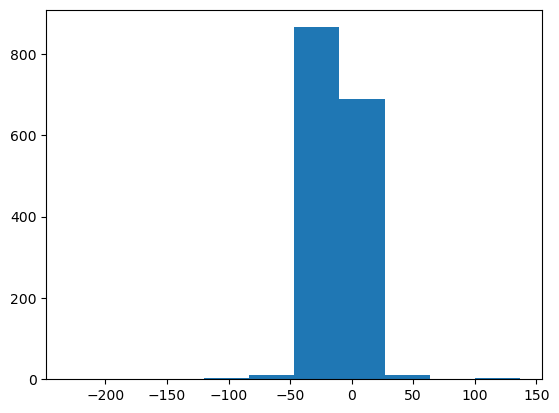

In [45]:
mean_diff_values =[item[1] for item in oxygen_adjusted_change]
plt.hist(mean_diff_values)
print('mean:' + str(np.mean(mean_diff_values)))
print('median: ' + str(np.median(mean_diff_values)))
print('min: ' + str(np.nanmin(mean_diff_values)) + ' max: ' + str(np.nanmax(mean_diff_values)))


In [110]:

argo_n = xr.load_dataset(argo_path+'1902383_Sprof.nc')
var_list = list(argo_n.data_vars)
#print(var_list)
#min(argo_n['JULD']).values

print((argo_n['DOXY_ADJUSTED'].values).size)
(argo_n['DOXY_ADJUSTED'].where(argo_n['PRES_ADJUSTED']>1400, drop=True).values).size

27030


1632

2. For each file, find all profiles with valid O2 data, save out lat/lon/date into an array


In [35]:
#wmo_list = list()

for n in range(last, len(argolist)):
    print(f' {n}' ' File: ' + argolist[n]) 

    #n = 0
    argo_n = xr.load_dataset(argo_path+argolist[n])
    argo_n = argo_n.set_coords(('PRES_ADJUSTED','LATITUDE','LONGITUDE','JULD'))
    
    var_list = list(argo_n.data_vars)
    
    if "DOXY_ADJUSTED" not in var_list:
        print('Skipping')
        continue
            
    doxy_trimmed = argo_n.DOXY_ADJUSTED.where(~np.isnan(argo_n.DOXY_ADJUSTED), drop=True)
    wmo_n = argo_n.PLATFORM_NUMBER.values.astype(int)[0]

    prof_loc = xr.Dataset()
    prof_loc['wmo']=(['N_PROF'],np.repeat(wmo_n,len(doxy_trimmed)))

    prof_loc['LATITUDE'] = (['N_PROF'], doxy_trimmed.LATITUDE.data)
    prof_loc['LONGITUDE'] = (['N_PROF'], doxy_trimmed.LONGITUDE.data)
    prof_loc['juld'] = (['N_PROF'],doxy_trimmed.JULD.data)
    #prof_loc['profile'] = (['N_PROF'],doxy_trimmed.CYCLE_NUMBER.data)
    #argo_n
    # append all files into one long xarray
    if n == 0:
        argo_all = prof_loc
    else:
        argo_all = xr.concat([argo_all,prof_loc], 'N_PROF')

    last = n + 1
argo_all

 0 File: 1901378_Sprof.nc
 1 File: 1901379_Sprof.nc
 2 File: 5901315_Sprof.nc
 3 File: 6901898_Sprof.nc
 4 File: 6901899_Sprof.nc
 5 File: 5901314_Sprof.nc
 6 File: 6903768_Sprof.nc
 7 File: 2900737_Sprof.nc
 8 File: 5904687_Sprof.nc
 9 File: 3900348_Sprof.nc
 10 File: 2900736_Sprof.nc
 11 File: 5904686_Sprof.nc
 12 File: 4901806_Sprof.nc
 13 File: 6901592_Sprof.nc
 14 File: 6903805_Sprof.nc
 15 File: 5905080_Sprof.nc
 16 File: 6903804_Sprof.nc
 17 File: 6901593_Sprof.nc
 18 File: 5904473_Sprof.nc
 19 File: 5904472_Sprof.nc
 20 File: 3900714_Sprof.nc
 21 File: 6901766_Sprof.nc
 22 File: 6901767_Sprof.nc
 23 File: 3900715_Sprof.nc
 24 File: 6903153_Sprof.nc
 25 File: 3902121_Sprof.nc
 26 File: 3902120_Sprof.nc
 27 File: 6903152_Sprof.nc
 28 File: 5904127_Sprof.nc
 29 File: 5906246_Sprof.nc
 30 File: 5906020_Sprof.nc
 31 File: 5906021_Sprof.nc
 32 File: 5904126_Sprof.nc
 33 File: 5906247_Sprof.nc
 34 File: 2901178_Sprof.nc
 35 File: 5906307_Sprof.nc
 36 File: 5902109_Sprof.nc
 37 File: 5

KeyboardInterrupt: 

Plotting

In [ ]:
# plotting all data
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
plt.plot(argo_all.LONGITUDE, argo_all.LATITUDE, linestyle='none', marker='.', markersize=1)
plt.show()

In [ ]:
# Average data by wmo. Longitude is currently incorrectly averaged, which is fixed below
argo_wmo = argo_all.groupby('wmo').mean()

avg_date = argo_all.juld.astype('int64').groupby(argo_all['wmo']).mean().astype('datetime64[ns]')

# calculate the year fraction for plotting
avg_date_dec_year = []
for i in avg_date.values:
    x = pd.Timestamp(i)
    y = toYearFraction(x)
    avg_date_dec_year.append(y)

In [ ]:
for wmo in argo_wmo.wmo:
    temp_LONGITUDE = argo_all.LONGITUDE.where(argo_all.wmo==wmo, drop=True)
    if (np.max(temp_LONGITUDE) - np.min(temp_LONGITUDE))>300:
        print('YES')
        new_mean = np.mean(xr.where(temp_LONGITUDE>=0, temp_LONGITUDE, temp_LONGITUDE+360))
        if new_mean>180:
            new_mean = new_mean-360
            old_mean = argo_wmo.LONGITUDE.where(argo_wmo.wmo==wmo, drop=True)

        #print('old mean: '  + str(old_mean.values))
        #print('new mean: '  + str(new_mean.values))

        # put new LONGITUDE mean back into argo_wmo
        argo_wmo['LONGITUDE'] = argo_wmo.LONGITUDE.where(argo_wmo.wmo!=wmo, new_mean)
        #updated_mean = argo_wmo.LONGITUDE.where(argo_wmo.wmo==wmo, drop=True)

        #print('new mean: '  + str(updated_mean.values))

        #new_mean
    #else:
        #print('NO')

In [ ]:
# Figure 1

fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
sct = plt.scatter(x=argo_wmo.LONGITUDE, 
            y=argo_wmo.LATITUDE, 
            c=avg_date_dec_year,cmap='turbo',s=10)
cbar = plt.colorbar(sct, fraction=.08, pad = 0.04, shrink=0.5)
cbar.set_label('Year', labelpad=15, fontsize=14)
plt.savefig(output_dir_figs+ 'Fig_1_O2_float_map_date.png')
plt.show()


Alternate version of Figure 1: gridded observational density

NameError: name 'argo_all' is not defined

/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


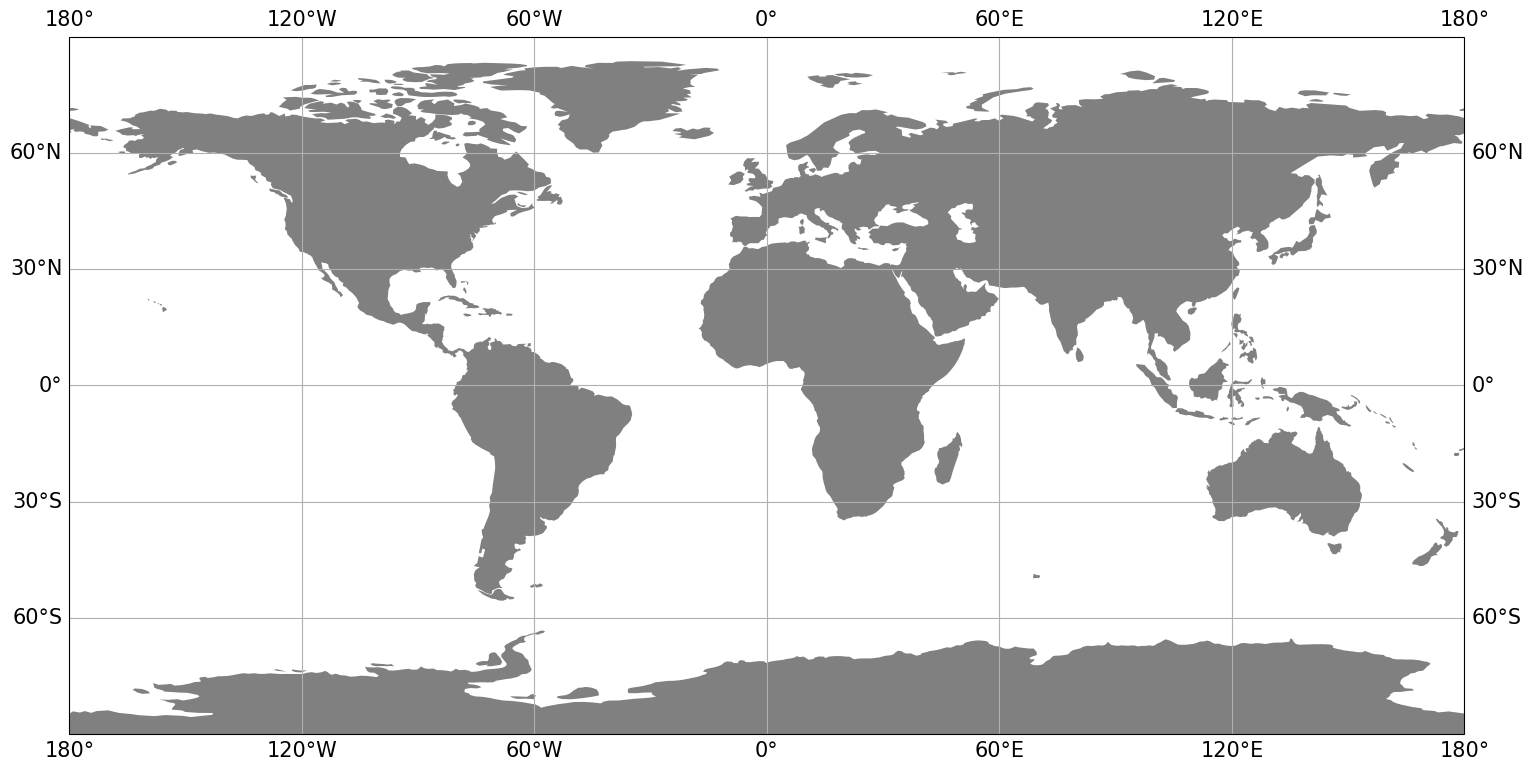

In [7]:
# Gridded density plot taken from J. Lilly's Distributional-Analysis code: http://www.jmlilly.net/course/labs/html/DistributionalAnalysis-Python.html
figsize=np.array([18, 12]);
projection=ccrs.PlateCarree();

cmap = plt.cm.get_cmap("Spectral_r", 64)

#for future reference, define a function to set up our map
def map_setup(figsize,projection):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=projection)
    ax.add_feature(cfeature.LAND, facecolor='grey')
    gl = ax.gridlines(draw_labels=True)  
    gl
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    return fig, ax 

fig, ax = map_setup(figsize,projection) 

dlatlon = 1
lonbins = np.arange(-180, 180, dlatlon)
latbins = np.arange(-80, 80, dlatlon)

hist = stats.binned_statistic_2d(argo_all.LATITUDE, argo_all.LONGITUDE, None, bins=[latbins, lonbins], statistic="count")
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
hist.statistic

image = plt.pcolormesh(lonbins, latbins, hist.statistic, cmap=cmap, shading="flat", transform=ccrs.PlateCarree()) 
plt.clim(0, 100) 

cbar = fig.colorbar(image, ax=ax, orientation='horizontal', fraction=0.1, aspect=40, pad=0.08)
               
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label='Number of Observations', size=20)
plt.savefig(output_dir_figs+ 'Fig_1v2_Argo_O2_Sampling_Density.png')

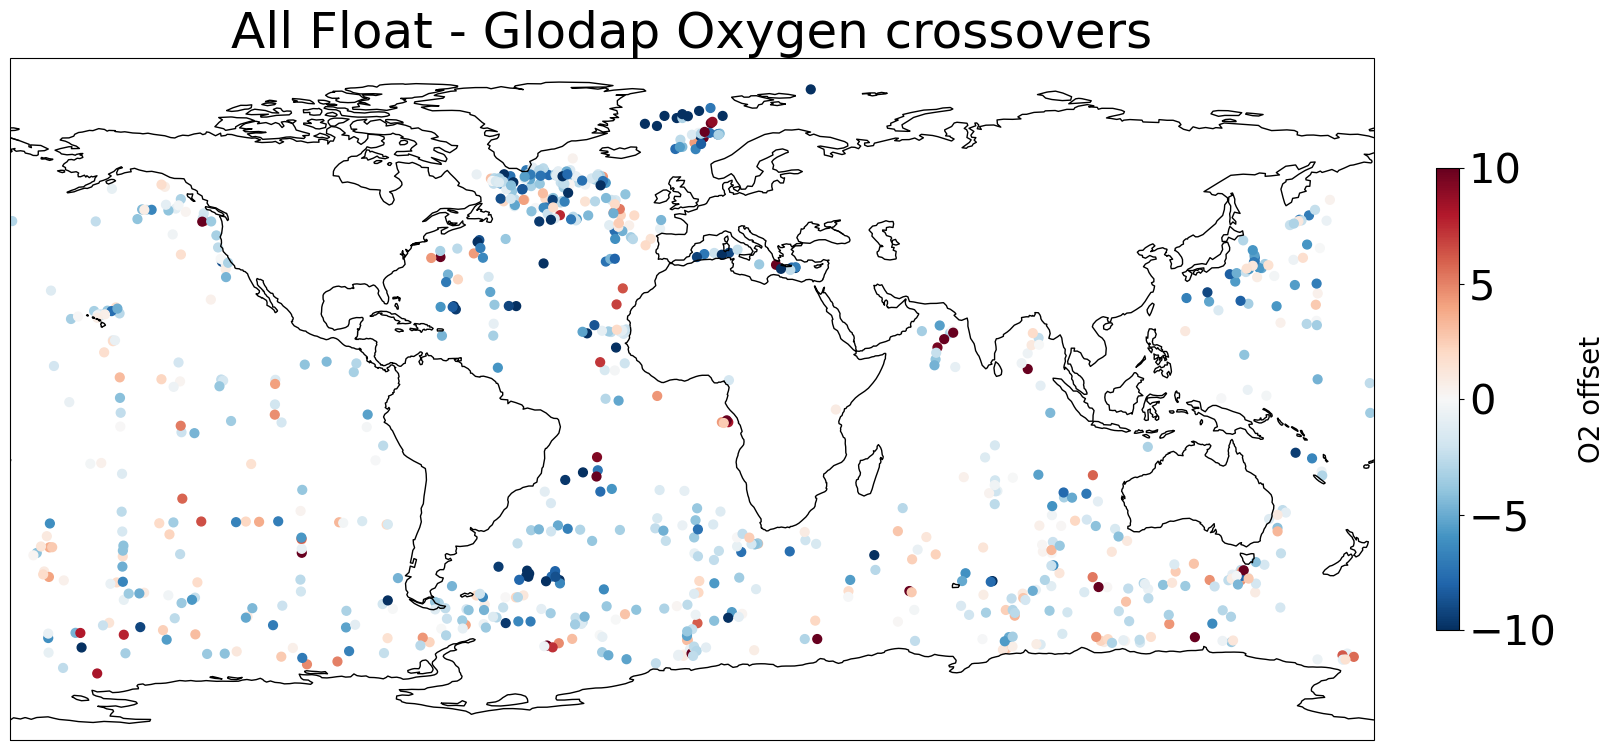

In [320]:
# Maps of offsets - need to fix longitude issue for this plot

fig = plt.figure(figsize=(20,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
sct = plt.scatter(glodap_offsets_mean.main_float_longitude, glodap_offsets_mean.main_float_latitude,
                c=glodap_offsets_mean.DOXY_ADJUSTED_offset, cmap='RdBu_r',s=40,vmin=-10,vmax=10)
cbar = plt.colorbar(sct, fraction=.08, pad = 0.04, shrink=0.5)
cbar.set_label('O2 offset', labelpad=15, fontsize=20)
plt.title('All Float - Glodap Oxygen crossovers')
plt.rcParams.update({'font.size': 30})

plt.savefig(output_dir_figs+ 'All Float - Glodap Oxygen crossovers.png')
plt.show()

Calculating number of floats with offsets significantly different from zero


In [6]:
if 'glodap_offsets' in locals():
    glodap_offsets.close()

glodap_offsets = xr.load_dataset(output_dir+'glodap_offsets.nc')
offsets_all_wmo = glodap_offsets.groupby(glodap_offsets.main_float_wmo)


In [18]:
offsets_all_wmo.count

<bound method DatasetGroupByReductions.count of DatasetGroupBy, grouped over 'main_float_wmo'
1004 groups with labels 1900722, 1900943, ..., 7900943.>

In [20]:
significant=0
for n,g in offsets_all_wmo:
    #print("n:", n, "g:", g)
    g_plot = g.DOXY_ADJUSTED_offset
    g_mean = np.nanmean(g_plot.values)
    t_stat, p_value = stats.ttest_1samp(a=g_plot, popmean=0, nan_policy='omit') ############
    
    if  p_value<.05:
        significant = significant+1

print("number significant", significant)


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_19601/2845830092.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value = stats.ttest_1samp(a=g_plot, popmean=0, nan_policy='omit') ############
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_19601/2845830092.py:5: RuntimeWarning: Mean of empty slice
  g_mean = np.nanmean(g_plot.values)


number significant 792


Figure 4. Load mean GLODAP offsets

In [7]:
glodap_offsets_mean = xr.load_dataset(output_dir+'glodap_offsets_floatmean_withcalibration.nc')
glodap_offsets_p = glodap_offsets_mean.to_dataframe()

In [8]:
parameter_a = 'o2_calib_air_group'
parameter_b = 'pH_group'
offsets_g = glodap_offsets_p.groupby(parameter_a)


In [9]:
offsets_pH = glodap_offsets_p.groupby([parameter_a, parameter_b])

In [14]:
glodap_offsets_mean['DOXY_ADJUSTED_offset'].std()

<xarray.DataArray 'DOXY_ADJUSTED_offset' ()>
array(5.97024338)

In [47]:
temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset']
t_stat_trim, p_value_trim = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############
print(p_value_trim)

CI_vals = stats.norm.interval(alpha=0.99, 
                 loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                 scale = stats.sem(temp_var[~np.isnan(temp_var)].values))

print(CI_vals[0])
print(CI_vals[1])


6.394141010258781e-25
-2.3685539654655465
-1.6288582835995618


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3874/3592277964.py:5: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_99 = stats.norm.interval(alpha=0.95,


In [51]:
CI_level

0.95

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3874/1779913737.py:17: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3874/1779913737.py:59: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3874/1779913737.py:82: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3874/1779913737.py:103: DeprecationWarning: Use of keyword argument 

+---------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
|               |   count |   mean |   std |     p_value |   95.0% CI low |   95.0% CI high |   median |   min |   max |
+===============+=========+========+=======+=============+================+=================+==========+=======+=======+
| All           |    1002 |   -2   |   6   | 6.39414e-25 |       -2.36855 |        -1.62886 |     -2.1 | -64   |  77.5 |
+---------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
| No air cal.   |     592 |   -1.9 |   4.8 | 3.58296e-20 |       -2.26025 |        -1.49005 |     -1.6 | -31.5 |  15.4 |
+---------------+---------+--------+-------+-------------+----------------+-----------------+----------+-------+-------+
| Air cal.      |     302 |   -3   |   5.1 | 6.39414e-25 |       -2.36855 |        -1.62886 |     -2.6 | -64   |  11.1 |
+---------------+---------+-----

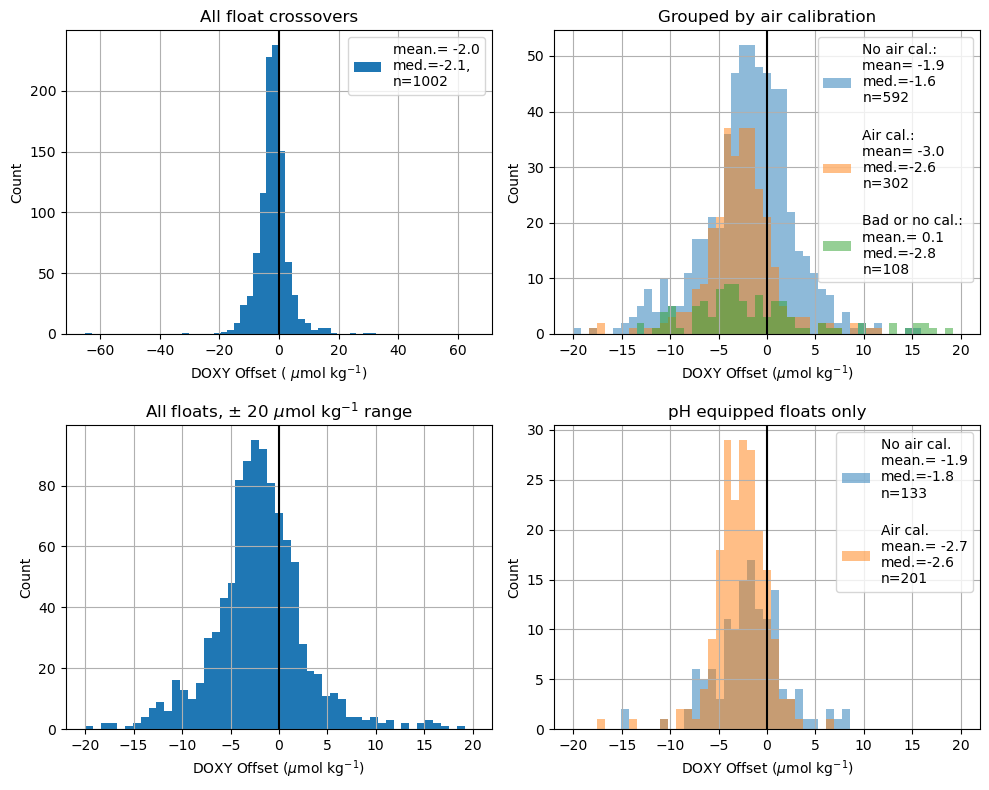

In [54]:
CI_level = 0.95

plt.figure(figsize=(10,8))

#All Float Crossovers
plt.subplot(2,2,1)
ncount = glodap_offsets_mean['DOXY_ADJUSTED_offset'].count()
nmean = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset'].mean(), decimals=1)
nstd = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset'].std(), decimals=1)
nmedian = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset'].median(), decimals=1)
nmin = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset'].min(), decimals=1)
nmax = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset'].max(), decimals=1)

temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset']
t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

CI_vals = stats.norm.interval(alpha=CI_level, 
                 loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                 scale = stats.sem(temp_var[~np.isnan(temp_var)].values))

o2_offset_data_table = [('All', ncount, nmean, nstd, p_value, CI_vals[0], CI_vals[1], nmedian, nmin, nmax)]
plt.hist(glodap_offsets_mean['DOXY_ADJUSTED_offset'], 
         bins=np.linspace(-65, 65, 61), label='mean.= ' + str(nmean.values) + 
         '\nmed.='+str(nmedian.values) + 
         ',\nn='+str(ncount.values)) # ,label=str(n)
#print(np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset'].median().values, decimals=1))
plt.grid()
plt.title('All float crossovers')
plt.xlabel(r'DOXY Offset ( $\mu$mol kg$^{-1}$)')
plt.ylabel('Count')
plt.axvline(x=0, color='k')
plt.legend()

# All float crossovers, zoomed in
plt.subplot(2,2,3)
plt.title('All floats, $\pm$ 20 $\mu$mol kg$^{-1}$ range')
plt.hist(glodap_offsets_mean['DOXY_ADJUSTED_offset'], 
         bins=np.linspace(-20, 20, 50),label='median='+str(nmedian.values) + 
         ', n='+str(ncount.values)) # ,label=str(n)
plt.grid()
plt.ylabel('Count')
plt.axvline(x=0, color='k')

plt.xlabel(r'DOXY Offset ($\mu$mol kg$^{-1}$)')

# Split into calibration group
plt.subplot(2,2,2)
No_air_cal_all = offsets_g.get_group('no air cal')
nmean = np.around(No_air_cal_all['DOXY_ADJUSTED_offset'].mean(), decimals=1)
nstd = np.around(No_air_cal_all['DOXY_ADJUSTED_offset'].std(), decimals=1)
nmedian = np.around(No_air_cal_all['DOXY_ADJUSTED_offset'].median(), decimals=1)
ncount = No_air_cal_all['DOXY_ADJUSTED_offset'].count() # only counts non-nan values
nmin = np.around(No_air_cal_all['DOXY_ADJUSTED_offset'].min(), decimals=1)
nmax = np.around(No_air_cal_all['DOXY_ADJUSTED_offset'].max(), decimals=1)

temp_var = No_air_cal_all['DOXY_ADJUSTED_offset']
t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

CI_vals = stats.norm.interval(alpha=CI_level, 
                 loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                 scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
o2_offset_data_table.append(('No air cal.', ncount, nmean, nstd, p_value, CI_vals[0], CI_vals[1], nmedian, nmin, nmax))


plt.hist(No_air_cal_all['DOXY_ADJUSTED_offset'], bins=np.linspace(-20, 20, 50),
             alpha=0.5,label='No air cal.: \nmean= ' + str(nmean) + '\nmed.='+str(nmedian) + 
         '\nn='+str(ncount) + '\n')



air_cal_all = offsets_g.get_group('air cal')
nmean = np.around(air_cal_all['DOXY_ADJUSTED_offset'].mean(), decimals=1)
nstd = np.around(air_cal_all['DOXY_ADJUSTED_offset'].std(), decimals=1)
nmedian = np.around(air_cal_all['DOXY_ADJUSTED_offset'].median(), decimals=1)
ncount = air_cal_all['DOXY_ADJUSTED_offset'].count() # only counts non-nan values
nmin = np.around(air_cal_all['DOXY_ADJUSTED_offset'].min(), decimals=1)
nmax = np.around(air_cal_all['DOXY_ADJUSTED_offset'].max(), decimals=1)

temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset']
t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

CI_vals = stats.norm.interval(alpha=CI_level, 
                 loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                 scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
o2_offset_data_table.append(('Air cal.', ncount, nmean, nstd, p_value, CI_vals[0], CI_vals[1], nmedian, nmin, nmax))

plt.hist(air_cal_all['DOXY_ADJUSTED_offset'], bins=np.linspace(-20, 20, 50),
             alpha=0.5,label='Air cal.: \nmean= ' + str(nmean) + '\nmed.='+str(nmedian) + 
         '\nn='+str(ncount) + '\n')


no_cal_all = offsets_g.get_group('no cal/bad')
nmean = np.around(no_cal_all['DOXY_ADJUSTED_offset'].mean(), decimals=1)
nstd = np.around(no_cal_all['DOXY_ADJUSTED_offset'].std(), decimals=1)
nmedian = np.around(no_cal_all['DOXY_ADJUSTED_offset'].median(), decimals=1)
ncount = no_cal_all['DOXY_ADJUSTED_offset'].count() # only counts non-nan values
nmin = np.around(no_cal_all['DOXY_ADJUSTED_offset'].min(), decimals=1)
nmax = np.around(no_cal_all['DOXY_ADJUSTED_offset'].max(), decimals=1)

temp_var = no_cal_all['DOXY_ADJUSTED_offset']
t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

CI_vals = stats.norm.interval(alpha=CI_level, 
                 loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                 scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
o2_offset_data_table.append(('No cal.', ncount, nmean, nstd, p_value, CI_vals[0], CI_vals[1], nmedian, nmin, nmax))

plt.hist(no_cal_all['DOXY_ADJUSTED_offset'], bins=np.linspace(-20, 20, 50),
             alpha=0.5,label='Bad or no cal.: \nmean.= ' + str(nmean) + '\nmed.='+str(nmedian) + 
         '\nn='+str(ncount))



#for n, group in offsets_g:
#    print(n)
#    nmean = np.around(group['DOXY_ADJUSTED_offset'].mean(), decimals=1)
#    nmedian = np.around(group['DOXY_ADJUSTED_offset'].median(), decimals=1)
#    ncount = group['DOXY_ADJUSTED_offset'].count()

    

plt.title('Grouped by air calibration')

plt.axvline(x=0, color='k')
plt.grid()
plt.xlabel(r'DOXY Offset ($\mu$mol kg$^{-1}$)')
plt.ylabel('Count')

plt.legend()

# pH equipped floats only 
plt.subplot(2,2,4)
plt.title('pH equipped floats only')

no_air_cal_ph = offsets_pH.get_group(('no air cal', 'pH'))
nmean = np.around(no_air_cal_ph['DOXY_ADJUSTED_offset'].mean(), decimals=1)
nmedian = np.around(no_air_cal_ph['DOXY_ADJUSTED_offset'].median(), decimals=1)
nstd = np.around(no_air_cal_ph['DOXY_ADJUSTED_offset'].std(), decimals=1)
nmin = np.around(no_air_cal_ph['DOXY_ADJUSTED_offset'].min(), decimals=1)
nmax = np.around(no_air_cal_ph['DOXY_ADJUSTED_offset'].max(), decimals=1)

ncount = no_air_cal_ph['DOXY_ADJUSTED_offset'].count()

temp_var = no_air_cal_ph['DOXY_ADJUSTED_offset']
t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

CI_vals = stats.norm.interval(alpha=CI_level, 
                 loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                 scale = stats.sem(temp_var[~np.isnan(temp_var)].values))

o2_offset_data_table.append(('pH - No cal.', ncount, nmean, nstd, p_value, CI_vals[0], CI_vals[1], nmedian, nmin, nmax))

plt.hist(no_air_cal_ph['DOXY_ADJUSTED_offset'], bins=np.linspace(-20, 20, 50),
             alpha=0.5,label='No air cal. \nmean.= ' + str(nmean) + '\nmed.='+str(nmedian) + 
         '\nn='+str(ncount) + '\n')
air_cal_ph = offsets_pH.get_group(('air cal', 'pH'))
nmean = np.around(air_cal_ph['DOXY_ADJUSTED_offset'].mean(), decimals=1)
nmedian = np.around(air_cal_ph['DOXY_ADJUSTED_offset'].median(), decimals=1)
ncount = air_cal_ph['DOXY_ADJUSTED_offset'].count()
nstd = np.around(air_cal_ph['DOXY_ADJUSTED_offset'].std(), decimals=1)
nmin = np.around(air_cal_ph['DOXY_ADJUSTED_offset'].min(), decimals=1)
nmax = np.around(air_cal_ph['DOXY_ADJUSTED_offset'].max(), decimals=1)

temp_var = air_cal_ph['DOXY_ADJUSTED_offset']
t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

CI_vals = stats.norm.interval(alpha=CI_level, 
                 loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                 scale = stats.sem(temp_var[~np.isnan(temp_var)].values))

o2_offset_data_table.append(('pH - Air cal.', ncount, nmean, nstd, p_value, CI_vals[0], CI_vals[1], nmedian, nmin, nmax))

plt.hist(air_cal_ph['DOXY_ADJUSTED_offset'], bins=np.linspace(-20, 20, 50),
             alpha=0.5,label='Air cal. \nmean.= ' + str(nmean) + '\nmed.='+str(nmedian) + 
         '\nn='+str(ncount))


#for n, group in offsets_pH:
#    if n[1] == 'no pH' or n[0] == 'no cal/bad':
#        continue
#    print(n)
#    nmean = np.around(group['DOXY_ADJUSTED_offset'].mean(), decimals=1)
#    nmedian = np.around(group['DOXY_ADJUSTED_offset'].median(), decimals=1)
#    ncount = group['DOXY_ADJUSTED_offset'].count()

plt.xlabel(r'DOXY Offset ($\mu$mol kg$^{-1}$)')
plt.ylabel('Count')
plt.axvline(x=0, color='k')

plt.legend()
    
plt.tight_layout()
plt.grid()

plt.savefig(output_dir_figs + 'Glodap_offsets_doxy_all_v4.png', dpi=300)

print(tabulate(o2_offset_data_table, headers=['count', 'mean', 'std', 'p_value', str(CI_level*100) + '% CI low', str(CI_level*100) + '% CI high', 'median', 'min', 'max'], tablefmt='grid'))


In [29]:
air_cal_all

,p_compare_min,p_compare_max,delta_dens,delta_spice,delta_press,dist,PRES_ADJUSTED_offset,PRES_ADJUSTED_glodap,PRES_ADJUSTED_float,TEMP_ADJUSTED_offset,...,project_name,plat_type,data_centre,pH_group,pH_sensor,nitrate_group,nitrate_sensor,DOXY_group,DOXY_sensor,ice_group
main_float_wmo,,,,,,,,,,,,,,,,,,,,,
1901360,1450.0,2000.0,0.005,0.005,100.0,100.0,7.146980,1697.671812,1704.818792,0.001907,...,BSH ...,APEX,IF,no pH,none,no nitrate,none,DOXY,AANDERAA_OPTODE_4330 ...,no ice
1901361,1450.0,2000.0,0.005,0.005,100.0,100.0,19.655882,1691.910294,1711.566176,0.000235,...,BSH ...,APEX,IF,no pH,none,no nitrate,none,DOXY,AANDERAA_OPTODE_4330 ...,no ice
1901362,1450.0,2000.0,0.005,0.005,100.0,100.0,17.421429,1695.721429,1713.142857,0.000088,...,BSH ...,APEX,IF,no pH,none,no nitrate,none,DOXY,AANDERAA_OPTODE_4330 ...,no ice
1901363,1450.0,2000.0,0.005,0.005,100.0,100.0,21.776389,1634.577778,1656.354167,0.001788,...,BSH ...,APEX,IF,no pH,none,no nitrate,none,DOXY,AANDERAA_OPTODE_4330 ...,no ice
1901364,1450.0,2000.0,0.005,0.005,100.0,100.0,23.725000,1611.757143,1635.482143,0.004576,...,BSH ...,APEX,IF,no pH,none,no nitrate,none,DOXY,AANDERAA_OPTODE_4330 ...,no ice
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6903571,1450.0,2000.0,0.005,0.005,100.0,100.0,11.210076,1753.049466,1764.259542,0.024983,...,NorArgo2 ...,ARVOR_D,IF,no pH,none,no nitrate,none,DOXY,AANDERAA_OPTODE_4330 ...,no ice
6903573,1450.0,2000.0,0.005,0.005,100.0,100.0,19.902941,1847.026471,1866.929412,0.052163,...,NorArgo2 ...,ARVOR_D,IF,no pH,none,no nitrate,none,DOXY,AANDERAA_OPTODE_4330 ...,no ice
6903574,1450.0,2000.0,0.005,0.005,100.0,100.0,63.103056,1739.966389,1803.069444,0.054687,...,NorArgo2 ...,PROVOR_III,IF,pH,SUNA_V2 ...,nitrate,SUNA_V2 ...,DOXY,AANDERAA_OPTODE_4330 ...,no ice


Calculating pH impact of oxygen bias - maybe supplemental figure

Load interpolated argo dataset

In [10]:
argo_interpolated = xr.load_dataset(data_dir + 'argo_interp_temp_100km_1450_to_2000_100m_0.005dens_0.005spice.nc')
argo_interp_wmo = argo_interpolated.groupby('wmo')

In [22]:
float_wmo_list = glodap_offsets_p.index.values


for n in range(0, float_wmo_list.shape[0]):
    wmo_n = float_wmo_list[n]

    if wmo_n ==5904693:
        print(n)
        break
    #argo_derived_n = xr.load_dataset(argo_path+ '../derived/' + str(wmo_n) + '_derived.nc')
    

    #if 'NITRATE_ADJUSTED' in argo_derived_n.keys():
    #    print(n)
    #    break

510


In [11]:
LIPHR_path = liar_dir


float_wmo_list = glodap_offsets_p.index.values
MeasIDVec = [1, 7, 3, 6]
MeasIDVec_no3 = [1, 7, 6]

last = 0

for n in range(0, float_wmo_list.shape[0]): #range(34, 35): 
    wmo_n = float_wmo_list[n]
    if glodap_offsets_p.pH_group[glodap_offsets_p.index==wmo_n].values=='no pH':
        continue
    
    # if oxygen offset is nan, then skip
    if np.isnan(glodap_offsets_p.DOXY_ADJUSTED_offset[glodap_offsets_p.index==wmo_n].values):
        continue

    print('N: ' + str(n) + ' ' + str(wmo_n) + ' started')
    
    argo_derived_n = xr.load_dataset(argo_path_derived+ str(wmo_n) + '_derived.nc')

    nprof = argo_derived_n.LATITUDE.shape[0]
    if nprof==1: # if there is only one profile, probably don't want to trust any offset
        continue

    # Check for presence of non-nan pH
    if ~np.any(~np.isnan(argo_derived_n['PH_IN_SITU_TOTAL_ADJUSTED'])):
        continue
    
    # initialize coordinate and measurement arrays
    Coordinates_all = np.empty([nprof, 3],dtype=float)
    Coordinates_all[:] = np.nan
       
    Measurements_all = np.empty([nprof, 4],dtype=float)
    Measurements_all[:] = np.nan

    Measurements_all_no3 = np.empty([nprof, 3],dtype=float)
    Measurements_all_no3[:] = np.nan
    for p in range(nprof):
        # load interpolated argo_data so that 1500 m data is present 
        argo_profile = argo_interp_wmo[wmo_n].isel(N_PROF=p)
        argo_profile.load()
        data_1500 = argo_profile.where(argo_profile.PRES_ADJUSTED==1500, drop=True) 
        if data_1500.LATITUDE.size==0:
            continue
        #index_1500 = argo_profile.PRES_ADJUSTED==1500 #argo_wmo[wmo_n].PRES_ADJUSTED[p,:]==1500

        #argo_wmo[5904659].PSAL_ADJUSTED[0,index_1500]
        Coordinates_all[p,:] = np.stack((data_1500.LONGITUDE.values, 
                            data_1500.LATITUDE.values, 
                            data_1500.PRES_ADJUSTED.values),
                            axis=1)
        Measurements_all[p,:] = np.stack((data_1500.PSAL_ADJUSTED.values, 
                             data_1500.TEMP_ADJUSTED.values, 
                             data_1500.NITRATE_ADJUSTED.values, 
                             data_1500.DOXY_ADJUSTED.values),
                             axis=1)
        
        Measurements_all_no3[p,:] = np.stack((data_1500.PSAL_ADJUSTED.values, 
                             data_1500.TEMP_ADJUSTED.values, 
                             data_1500.DOXY_ADJUSTED.values),
                             axis=1)
        
    # calculate LIPHR pH at 1500 m using original data from all profiles
    orig_pH = carbon_utils.LIPHR_matlab(LIPHR_path,
                                    Coordinates_all.tolist(),
                                    Measurements_all.tolist(),
                                    MeasIDVec, 
                                    OAAdjustTF = False)  

    # create a second Measurements array that adjusts oxygen according to the mean glodap bias. Subtract the offset to correct it properly
    Measurements_o2_offset = np.concatenate(([Measurements_all[:,0]], 
                                  [Measurements_all[:,1]],
                                  [Measurements_all[:,2]],
                                  [Measurements_all[:,3]] - 
                                  glodap_offsets_p.DOXY_ADJUSTED_offset[glodap_offsets_p.index==wmo_n].values))
    Measurements_o2_offset = np.transpose(Measurements_o2_offset)
    
    # create a measurements_offset array that only has S, O2, and T - for use with LIAR and LINR:
    Measurements_no3_o2_offset = np.concatenate(([Measurements_all_no3[:,0]], 
                                    [Measurements_all_no3[:,1]],
                                    [Measurements_all_no3[:,2]] - 
                                    glodap_offsets_p.DOXY_ADJUSTED_offset[glodap_offsets_p.index==wmo_n].values))
    Measurements_no3_o2_offset = np.transpose(Measurements_no3_o2_offset)


    # calculate LIPHR pH at 1500 m with oxygen adjustment
    pH_o2_adjust = carbon_utils.LIPHR_matlab(LIPHR_path,
                                    Coordinates_all.tolist(),
                                    Measurements_o2_offset.tolist(),
                                    MeasIDVec, 
                                    OAAdjustTF = False)  
    argo_derived_n['pH_1500_orig_LIPHR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
    argo_derived_n.pH_1500_orig_LIPHR[:] = orig_pH[:,0]

     # remove data when oxygen is NaN - avoids biasing difference low
    pH_o2_adjust_no_nan = np.copy(pH_o2_adjust)
    pH_o2_adjust_no_nan[np.isnan(Measurements_all[:,3])] = np.nan
   
    argo_derived_n['pH_1500_O2_ADJUST_LIPHR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
    argo_derived_n.pH_1500_O2_ADJUST_LIPHR[:] = pH_o2_adjust_no_nan[:,0]
    # difference between pH_O2_orig_LIPHR and PH_IN_SITU_TOTAL_ADJUSTED- should that average 0? 
    # Impact of O2 can be seen in the test_pH minus new_pH average 
    
    
    argo_derived_n['PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST'] = \
        argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(pH_o2_adjust_no_nan - orig_pH)
    
    # Calculate TALK wo o2 correction
    orig_TALK = carbon_utils.LIAR_matlab(LIPHR_path,
                                        Coordinates_all.tolist(),
                                        Measurements_all_no3.tolist(),
                                        MeasIDVec_no3)  
    argo_derived_n['TALK_1500_orig_LIAR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
    argo_derived_n.TALK_1500_orig_LIAR[:] = orig_TALK[:,0]

    # TALK w/ O2 correction
    TALK_o2_adjust = carbon_utils.LIAR_matlab(LIPHR_path,
                                        Coordinates_all.tolist(),
                                        Measurements_no3_o2_offset.tolist(),
                                        MeasIDVec_no3)  
    
    # remove data when oxygen is NaN - avoids biasing difference low
    TALK_o2_adjust_no_nan = np.copy(TALK_o2_adjust)
    TALK_o2_adjust_no_nan[np.isnan(Measurements_all_no3[:,2])] = np.nan
    
    argo_derived_n['TALK_1500_O2_ADJUST_LIAR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
    argo_derived_n.TALK_1500_O2_ADJUST_LIAR[:] = TALK_o2_adjust_no_nan[:,0]

   
    #argo_derived_n['TALK_w_O2_ADJUST'] = \
    #    argo_derived_n.TALK_LIAR + np.nanmean(TALK_o2_adjust_no_nan - orig_TALK)


    # do additional nitrate calculations if NITRATE is present
    if 'NITRATE_ADJUSTED' in argo_derived_n.keys():
            
        # calculate LINR NO3 at 1500m using original data from all profiles
        orig_no3 = carbon_utils.LINR_matlab(LIPHR_path,
                                        Coordinates_all.tolist(),
                                        Measurements_all_no3.tolist(),
                                        MeasIDVec_no3)  
        
        argo_derived_n['NO3_1500_orig_LINR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
        argo_derived_n.NO3_1500_orig_LINR[:] = orig_no3[:,0]

        # calculate LINR NO3 at 1500m with oxygen adjustment:
        Measurements_no3_o2_offset = np.concatenate(([Measurements_all_no3[:,0]], 
                                    [Measurements_all_no3[:,1]],
                                    [Measurements_all_no3[:,2]] - 
                                    glodap_offsets_p.DOXY_ADJUSTED_offset[glodap_offsets_p.index==wmo_n].values))

        Measurements_no3_o2_offset = np.transpose(Measurements_no3_o2_offset)

        no3_o2_adjust = carbon_utils.LINR_matlab(LIPHR_path,
                                        Coordinates_all.tolist(),
                                        Measurements_no3_o2_offset.tolist(),
                                        MeasIDVec_no3)  
        # remove data when oxygen is NaN - avoids biasing difference low
        no3_o2_adjust_no_nan = np.copy(no3_o2_adjust)
        no3_o2_adjust_no_nan[np.isnan(Measurements_all[:,3])] = np.nan

        argo_derived_n['NO3_1500_o2_adjust'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
        argo_derived_n.NO3_1500_o2_adjust[:] = no3_o2_adjust_no_nan[:,0]
        
        argo_derived_n['NITRATE_ADJUSTED_w_O2_ADJUST'] = \
            argo_derived_n.NITRATE_ADJUSTED + np.nanmean(no3_o2_adjust_no_nan - orig_no3)
    
        # Calculate pH at 1500 m with ONLY nitrate impacts
        Measurements_no3_offset_for_pH = np.concatenate(([Measurements_all[:,0]], 
                                        [Measurements_all[:,1]],
                                        [Measurements_all[:,2] + np.nanmean(no3_o2_adjust - orig_no3)],
                                        [Measurements_all[:,3]]))
        
        Measurements_no3_offset_for_pH = np.transpose(Measurements_no3_offset_for_pH)
        pH_no3_adjust = carbon_utils.LIPHR_matlab(LIPHR_path,
                                    Coordinates_all.tolist(),
                                    Measurements_no3_offset_for_pH.tolist(),
                                    MeasIDVec, 
                                    OAAdjustTF = False)  
        
        # remove data when oxygen is NaN - avoids biasing difference low
        pH_no3_adjust_no_nan = np.copy(pH_no3_adjust)
        pH_no3_adjust_no_nan[np.isnan(Measurements_all[:,3])] = np.nan

        argo_derived_n['pH_1500_no3_LIPHR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
        argo_derived_n.pH_1500_no3_LIPHR[:] = pH_no3_adjust_no_nan[:,0]

        # apply mean pH difference at 1500 m to full pH profiles and save
        argo_derived_n['PH_w_NO3_ADJUST'] = \
            argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(pH_no3_adjust_no_nan - orig_pH)
        

        Measurements_o2_offset_no3_offset = np.concatenate(([Measurements_all[:,0]], 
                                        [Measurements_all[:,1]],
                                        [Measurements_all[:,2] + np.nanmean(no3_o2_adjust - orig_no3)],
                                        [Measurements_all[:,3]] - 
                                        glodap_offsets_p.DOXY_ADJUSTED_offset[glodap_offsets_p.index==wmo_n].values))
        Measurements_o2_offset_no3_offset = np.transpose(Measurements_o2_offset_no3_offset)

        # Calculate pH at 1500 m with both oxygen and nitrate impacts
        pH_o2_adjust_no3_adjust = carbon_utils.LIPHR_matlab(LIPHR_path,
                                    Coordinates_all.tolist(),
                                    Measurements_o2_offset_no3_offset.tolist(),
                                    MeasIDVec, 
                                    OAAdjustTF = False)  
        # remove data when oxygen is NaN - avoids biasing difference low
        pH_o2_adjust_no3_adjust_no_nan = np.copy(pH_o2_adjust_no3_adjust)
        pH_o2_adjust_no3_adjust_no_nan[np.isnan(Measurements_all[:,3])] = np.nan

        argo_derived_n['pH_1500_o2_no3_LIPHR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
        argo_derived_n.pH_1500_o2_no3_LIPHR[:] = pH_o2_adjust_no3_adjust_no_nan[:,0]

               # apply mean pH difference at 1500 m to full pH profiles and save
        argo_derived_n['PH_w_O2_NO3_ADJUST'] = \
            argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(pH_o2_adjust_no3_adjust_no_nan - orig_pH)

        # removing this section - nitrate is not used in LIAR, so there is no reason to re-calculate full depth TALK or consider the impact of nitrate 
        ## Calculate full-depth alkalinity using adjusted nitrate - code copied from float_bgc_bias_correction
        ##repeat lats, lons to match pressure shape
        #lons_rep = np.tile(argo_derived_n.LONGITUDE.values,(argo_derived_n.PRES_ADJUSTED.shape[1],1)).T
        #lats_rep = np.tile(argo_derived_n.LATITUDE.values,(argo_derived_n.PRES_ADJUSTED.shape[1],1)).T

        #set Si and PO4 inputs
        #if nitrate, then use redfield for Si and PO4?, otherwise set to 0    
        #SI = argo_n.NITRATE_ADJUSTED*2.5
        #SI.where(~np.isnan(SI), 0)
        #PO4 = argo_n.NITRATE_ADJUSTED/16
        #PO4.where(~np.isnan(PO4),0)
        #Coordinates_TALK = np.stack((lons_rep.flatten(), 
        #                lats_rep.flatten(), 
        #                argo_derived_n.PRES_ADJUSTED.values.flatten()),
        #                axis=1)
        #Measurements_TALK = np.stack((argo_derived_n.PSAL_ADJUSTED.values.flatten(), 
        #                    argo_derived_n.TEMP_ADJUSTED.values.flatten(), 
        #                    argo_derived_n.NITRATE_ADJUSTED_w_O2_ADJUST.values.flatten(), 
        #                    argo_derived_n.DOXY_ADJUSTED.values.flatten()),
        #                    axis=1)
        #    Measurements_TALK_orig = np.stack((argo_derived_n.PSAL_ADJUSTED.values.flatten(), 
        #                   argo_derived_n.TEMP_ADJUSTED.values.flatten(), 
        #                   argo_derived_n.NITRATE_ADJUSTED.values.flatten(), 
        #                   argo_derived_n.DOXY_ADJUSTED.values.flatten()),
        #                   axis=1)
        #MeasIDVec_TALK = [1, 7, 3, 6]
                       

        #results = carbon_utils.LIAR_matlab(LIPHR_path,
        #                                       Coordinates_TALK.tolist(),
        #                                       Measurements_TALK.tolist(),
        #                                       MeasIDVec_TALK,
        #                                       VerboseTF=False)                                  

        #argo_derived_n['TALK_w_NO3_ADJUST'] = (['N_PROF','N_LEVELS'],
        #                        np.reshape(np.asarray(results),argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED.shape))


        #results = carbon_utils.LIAR_matlab(LIPHR_path,
        #                                       Coordinates_TALK.tolist(),
        #                                       Measurements_TALK_orig.tolist(),
        #                                       MeasIDVec_TALK,
        #                                       VerboseTF=False)  

        #argo_derived_n['TALK_LIAR_recalc'] = (['N_PROF','N_LEVELS'],
        #                        np.reshape(np.asarray(results),argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED.shape))

    argo_derived_n.to_netcdf(argo_path_derived+ str(wmo_n) + '_derived_2.nc')
    print(str(wmo_n)+ ' finished')

    last=n

N: 33 1902303 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
2 seconds elapsed... now using eqn. 5: S Theta N AOU.
3 seconds elapsed... now using eqn. 6: S Theta N.
3 seconds elapsed... now using eqn. 7: S Theta AOU.
3 seconds elapsed... now using eqn. 8: S Theta.
3 seconds elapsed... now using eqn. 13: S N AOU.
3 seconds elapsed... now using eqn. 14: S N.
3 seconds elapsed... now using eqn. 15: S AOU.
3 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 3 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desi

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 2 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
4903026 finished
N: 273 4903273 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 2 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
49034

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5903893 finished
N: 448 5904124 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now us

LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specif

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5904396 finished
N: 468 5904397 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_16765/4258933786.py:108: RuntimeWarning: Mean of empty slice
  argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(pH_o2_adjust_no_nan - orig_pH)
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_16765/4258933786.py:168: RuntimeWarning: Mean of empty slice
  argo_derived_n.NITRATE_ADJUSTED + np.nanmean(no3_o2_adjust_no_nan - orig_no3)
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_16765/4258933786.py:173: RuntimeWarning: Mean of empty slice
  [Measurements_all[:,2] + np.nanmean(no3_o2_adjust - orig_no3)],


By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_16765/4258933786.py:192: RuntimeWarning: Mean of empty slice
  argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(pH_no3_adjust_no_nan - orig_pH)
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_16765/4258933786.py:197: RuntimeWarning: Mean of empty slice
  [Measurements_all[:,2] + np.nanmean(no3_o2_adjust - orig_no3)],


By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5904473 finished
N: 479 5904474 started


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_16765/4258933786.py:217: RuntimeWarning: Mean of empty slice
  argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(pH_o2_adjust_no3_adjust_no_nan - orig_pH)


By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5904657 finished
N: 496 5904658 started
By Default

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5904674 finished
N: 509 5904675 started
By Default, all equations with enough input variables will be used, but only the estimate with the l

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_16765/4258933786.py:108: RuntimeWarning: Mean of empty slice
  argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(pH_o2_adjust_no_nan - orig_pH)
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_16765/4258933786.py:168: RuntimeWarning: Mean of empty slice
  argo_derived_n.NITRATE_ADJUSTED + np.nanmean(no3_o2_adjust_no_nan - orig_no3)
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_16765/4258933786.py:173: RuntimeWarning: Mean of empty slice
  [Measurements_all[:,2] + np.nanmean(no3_o2_adjust - orig_no3)],


By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_16765/4258933786.py:192: RuntimeWarning: Mean of empty slice
  argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(pH_no3_adjust_no_nan - orig_pH)
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_16765/4258933786.py:197: RuntimeWarning: Mean of empty slice
  [Measurements_all[:,2] + np.nanmean(no3_o2_adjust - orig_no3)],


By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5904680 finished
N: 515 5904682 started


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_16765/4258933786.py:217: RuntimeWarning: Mean of empty slice
  argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.nanmean(pH_o2_adjust_no3_adjust_no_nan - orig_pH)


By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5904684 finished
N: 518 5904685 started
By Default, all equations with enough input variables will be used, but only the estimate with the l

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

5904761 finished
N: 528 5904763 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specif

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5904856 finished
N: 550 5904857 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now us

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5905075 finished
N: 571 5905076 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 2 seconds.
5905109 finished
N: 594 5905130 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5905376 finished
N: 619 5905377 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If 

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5905638 finished
N: 637 5905639 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now us

1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By De

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 2 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5905983 finished
N: 650 5905985 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
59059

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

5906026 finished
N: 674 5906030 started
N: 675 5906031 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multipl

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If 

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 2 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 2 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 2 seconds.
5906222 finished
N: 709 5906224 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now us

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 2 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5906246 finished
N: 723 5906247 started
By Default, all equations with enough input variables wil

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5906309 finished
N: 741 5906310 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 2 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 2 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

5906438 finished
N: 760 5906439 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 2 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5906474 finished
N: 774 5906486 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
5906510 finished
N: 793 5906511 started
N: 794 5906512 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multipl

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with th

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 2 seconds.
5906571 finished
N: 832 5906580 started
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now us

By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the

1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed..

1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 2 seconds.
By Default, all equations with enough input variables will be used, but only the estimate with the lowest uncertainty will be returned.  If outputs from multiple equations are desired, specify the desired equations with the Equations input and include the input argument pair setting MinUncEstTF to false.
1 seconds elapsed... now using eqn. 5: S Theta N AOU.
1 seconds elapsed... now using eqn. 6: S Theta N.
1 seconds elapsed... now using eqn. 7: S Theta AOU.
1 seconds elapsed... now using eqn. 8: S Theta.
1 seconds elapsed... now using eqn. 13: S N AOU.
1 seconds elapsed... now using eqn. 14: S N.
1 seconds elapsed... now using eqn. 15: S AOU.
1 seconds elapsed... now using eqn. 16: S.
Picking the outputs with the lowest uncertainties.
LIPHR finished after 1 seconds.
By De

In [180]:
#plt.subplot(311)
#plt.plot(argo_derived_n['JULD_LOCATION'], pH_o2_adjust_no_nan)
#plt.plot(argo_derived_n['JULD_LOCATION'], orig_pH)
#plt.xlim([pd.Series(argo_derived_n.JULD_LOCATION).min(), pd.Series(argo_derived_n.JULD_LOCATION).max()])

#plt.subplot(312)
#plt.plot(argo_derived_n['JULD_LOCATION'], pH_o2_adjust_no_nan - orig_pH)
#plt.xlim([pd.Series(argo_derived_n.JULD_LOCATION).min(), pd.Series(argo_derived_n.JULD_LOCATION).max()])

#plt.subplot(313)
#plt.plot(argo_derived_n['JULD_LOCATION'], Measurements_all_no3[:,2])
#plt.xlim([pd.Series(argo_derived_n.JULD_LOCATION).min(), pd.Series(argo_derived_n.JULD_LOCATION).max()])


In [42]:
# remove data when oxygen is NaN - avoids biasing difference low
pH_o2_adjust_no_nan = np.copy(pH_o2_adjust)
pH_o2_adjust_no_nan[np.isnan(Measurements_all[:,3])] = np.nan

pH_o2_adjust_no_nan[:,0]


array([7.84470211, 7.83738684, 7.83647036, 7.84043858, 7.83568368,
       7.83417733, 7.83295194, 7.83391699, 7.82904552, 7.82928272,
       7.82753443, 7.83076871, 7.82779968, 7.82809227, 7.83179305,
       7.8320701 , 7.8336536 , 7.83648838, 7.83378395, 7.83469475,
       7.83429388, 7.83235592, 7.83317589, 7.83687226, 7.83133886,
       7.83260608, 7.83077465, 7.83220221, 7.82819108, 7.83751182,
       7.8378642 , 7.83522634, 7.83832009, 7.8441581 , 7.83699544,
       7.83954015, 7.83665263, 7.83942414, 7.83636154, 7.83603198,
       7.84586427, 7.84088743, 7.83677252, 7.83713865, 7.8360675 ,
       7.83819413, 7.83701757, 7.83004255, 7.83308466, 7.83336405,
       7.83074337, 7.83130354, 7.8294587 , 7.83182318, 7.83182274,
       7.82856316, 7.83148636, 7.83153736, 7.83195096, 7.82854859,
       7.83034162, 7.82892233, 7.82797075, 7.83120157, 7.82835428,
       7.82999392, 7.83287912, 7.83306594, 7.83187352, 7.83291615,
       7.83208327, 7.83340782, 7.83241001, 7.83108848, 7.82910

Calculate and plot pCO2 impacts
Load all derived_2.nc files, read in offset and pH impacts, plot 

In [12]:
derivedlist = []
for file in os.listdir(argo_path_derived):
    if file.endswith('derived_2.nc'):
        derivedlist.append(file)

#last = 0

In [182]:
# open derivedlist files, check if there are new pH values, then collect o2 offsets and average pH impact:
#pH_impact = list()
#o2_offset = list()
#o2_1500 = list()
#temp_1500 = list()
#sal_1500 = list()
#no3_1500 = list()

#derivedlist

In [13]:

for n in range(0, len(derivedlist)):
        
        print(f' {n}' + ' out of: ' + str(len(derivedlist)) + ' File: ' + derivedlist[n]) 
        argo_n = xr.load_dataset(argo_path_derived + derivedlist[n])
        var_list = list(argo_n.data_vars)
        wmo_n = argo_n['wmo']

        if "PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST" not in var_list:
                print('Skipping')
                continue

       # mean_pH_impact_n = np.nanmean(argo_n['pH_1500_O2_ADJUST_LIPHR'] - argo_n['pH_1500_orig_LIPHR'])
        #pH_impact.append(mean_pH_impact_n)

        #o2_offset_n = glodap_offsets_p.DOXY_ADJUSTED_offset[glodap_offsets_p.index==wmo_n.values].values
        #o2_offset.append(o2_offset_n)

        # find 1500m data and save out to explore sensitivity of pH to O2
        #first_filt = argo_n.where(argo_n.PRES_ADJUSTED>1450, drop=True)
        #second_filt = first_filt.where(first_filt.PRES_ADJUSTED<1550, drop=True)
        
        #o2_1500.append(np.nanmean(second_filt.DOXY_ADJUSTED))
        #temp_1500.append(np.nanmean(second_filt.TEMP_ADJUSTED))
        #sal_1500.append(np.nanmean(second_filt.PSAL_ADJUSTED))

        if 'TALK_LIAR' not in argo_n.keys():
                continue

        if 'NITRATE_ADJUSTED' in argo_n.keys():
                SI = argo_n.NITRATE_ADJUSTED*2.5
                SI.where(~np.isnan(SI), 0)
                PO4 = argo_n.NITRATE_ADJUSTED/16
                PO4.where(~np.isnan(PO4),0)
        else:
                SI = np.zeros((argo_n.PH_IN_SITU_TOTAL_ADJUSTED.shape))
                PO4 = np.zeros((argo_n.PH_IN_SITU_TOTAL_ADJUSTED.shape))
        # Calculate pCO2 with all original values
        # replace any negative pH values with nans:
        argo_n['PH_IN_SITU_TOTAL_ADJUSTED'] = \
                argo_n.PH_IN_SITU_TOTAL_ADJUSTED.where(argo_n.PH_IN_SITU_TOTAL_ADJUSTED>0)

        results = pyco2.sys(
                par1=argo_n.TALK_LIAR, 
                par2=argo_n.PH_IN_SITU_TOTAL_ADJUSTED,
                par1_type=1,
                par2_type=3,
                temperature=argo_n.TEMP_ADJUSTED, 
                pressure=argo_n.PRES_ADJUSTED, 
                salinity=argo_n.PSAL_ADJUSTED, 
                temperature_out=argo_n.TEMP_ADJUSTED, #fixed 25C temperature
                pressure_out=argo_n.PRES_ADJUSTED,
                total_silicate=SI,
                total_phosphate=PO4,
                opt_pH_scale = 1, #total
                opt_k_carbonic=10, #Lueker et al. 2000
                opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
                opt_total_borate=2, # Lee et al. 2010
                opt_k_fluoride=2, # Perez and Fraga 1987
                opt_buffers_mode=1,
        )
        argo_n['pCO2_pH_orig_TALK_orig'] = (['N_PROF','N_LEVELS'],results['pCO2'])  

        # Calculate pCO2 including only the impact of adjusting oxygen on pH MLR
        # replace any negative pH values with nans:
        argo_n['PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST'] = \
                argo_n.PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST.where(argo_n.PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST>0)

        results = pyco2.sys(
                par1=argo_n.TALK_LIAR, 
                par2=argo_n.PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST,
                par1_type=1,
                par2_type=3,
                temperature=argo_n.TEMP_ADJUSTED, 
                pressure=argo_n.PRES_ADJUSTED, 
                salinity=argo_n.PSAL_ADJUSTED, 
                temperature_out=argo_n.TEMP_ADJUSTED, #fixed 25C temperature
                pressure_out=argo_n.PRES_ADJUSTED,
                total_silicate=SI,
                total_phosphate=PO4,
                opt_pH_scale = 1, #total
                opt_k_carbonic=10, #Lueker et al. 2000
                opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
                opt_total_borate=2, # Lee et al. 2010
                opt_k_fluoride=2, # Perez and Fraga 1987
                opt_buffers_mode=1,
        )
        argo_n['pCO2_pH_O2_TALK_orig'] = (['N_PROF','N_LEVELS'],results['pCO2'])  

        if 'PH_w_NO3_ADJUST' in argo_n.keys():
                # Calculate pCO2 including only the impact of adjusting nitrate on pH MLR
                # replace any negative pH values with nans:
                argo_n['PH_w_NO3_ADJUST'] = \
                        argo_n.PH_w_NO3_ADJUST.where(argo_n.PH_w_NO3_ADJUST>0)

                results = pyco2.sys(
                        par1=argo_n.TALK_LIAR, 
                        par2=argo_n.PH_w_NO3_ADJUST,
                        par1_type=1,
                        par2_type=3,
                        temperature=argo_n.TEMP_ADJUSTED, 
                        pressure=argo_n.PRES_ADJUSTED, 
                        salinity=argo_n.PSAL_ADJUSTED, 
                        temperature_out=argo_n.TEMP_ADJUSTED, #fixed 25C temperature
                        pressure_out=argo_n.PRES_ADJUSTED,
                        total_silicate=SI,
                        total_phosphate=PO4,
                        opt_pH_scale = 1, #total
                        opt_k_carbonic=10, #Lueker et al. 2000
                        opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
                        opt_total_borate=2, # Lee et al. 2010
                        opt_k_fluoride=2, # Perez and Fraga 1987
                        opt_buffers_mode=1,
                )
                argo_n['pCO2_pH_NO3_TALK_orig'] = (['N_PROF','N_LEVELS'],results['pCO2'])  

        # if 'TALK_w_NO3_ADJUST' in argo_n.keys():
                ## Calculate pCO2 with ONLY TALK change due to Nitrate  
                #results = pyco2.sys(
                #        par1=argo_n.TALK_w_NO3_ADJUST, 
                #        par2=argo_n.PH_IN_SITU_TOTAL_ADJUSTED,
                #         par1_type=1,
                #         par2_type=3,
                #         temperature=argo_n.TEMP_ADJUSTED, 
                #         pressure=argo_n.PRES_ADJUSTED, 
                #         salinity=argo_n.PSAL_ADJUSTED, 
                #         temperature_out=argo_n.TEMP_ADJUSTED, #fixed 25C temperature
                #         pressure_out=argo_n.PRES_ADJUSTED,
                #         total_silicate=SI,
                #         total_phosphate=PO4,
                #         opt_pH_scale = 1, #total
                #         opt_k_carbonic=10, #Lueker et al. 2000
                #         opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
                #         opt_total_borate=2, # Lee et al. 2010
                #         opt_k_fluoride=2, # Perez and Fraga 1987
                #         opt_buffers_mode=1,
                # )
                # argo_n['pCO2_pH_orig_TALK_NO3'] = (['N_PROF','N_LEVELS'],results['pCO2'])  

                # # Calculate pCO2 with BOTH pH change due to NO3 and TALK change due to Nitrate  
                # results = pyco2.sys(
                #         par1=argo_n.TALK_w_NO3_ADJUST, 
                #         par2=argo_n.PH_w_NO3_ADJUST,
                #         par1_type=1,
                #         par2_type=3,
                #         temperature=argo_n.TEMP_ADJUSTED, 
                #         pressure=argo_n.PRES_ADJUSTED, 
                #         salinity=argo_n.PSAL_ADJUSTED, 
                #         temperature_out=argo_n.TEMP_ADJUSTED, #fixed 25C temperature
                #         pressure_out=argo_n.PRES_ADJUSTED,
                #         total_silicate=SI,
                #         total_phosphate=PO4,
                #         opt_pH_scale = 1, #total
                #         opt_k_carbonic=10, #Lueker et al. 2000
                #         opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
                #         opt_total_borate=2, # Lee et al. 2010
                #         opt_k_fluoride=2, # Perez and Fraga 1987
                #         opt_buffers_mode=1,
                # )
                # argo_n['pCO2_pH_NO3_TALK_NO3'] = (['N_PROF','N_LEVELS'],results['pCO2']) 

                                
        if 'PH_w_O2_NO3_ADJUST' in argo_n.keys():
                # pCO2 including pH adjusted for O2 and NO3
                # replace any negative pH values with nans:
                argo_n['PH_w_O2_NO3_ADJUST'] = \
                        argo_n.PH_w_O2_NO3_ADJUST.where(argo_n.PH_w_O2_NO3_ADJUST>0)

                results = pyco2.sys(
                        par1=argo_n.TALK_LIAR, 
                        par2=argo_n.PH_w_O2_NO3_ADJUST,
                        par1_type=1,
                        par2_type=3,
                        temperature=argo_n.TEMP_ADJUSTED, 
                        pressure=argo_n.PRES_ADJUSTED, 
                        salinity=argo_n.PSAL_ADJUSTED, 
                        temperature_out=argo_n.TEMP_ADJUSTED, #fixed 25C temperature
                        pressure_out=argo_n.PRES_ADJUSTED,
                        total_silicate=SI,
                        total_phosphate=PO4,
                        opt_pH_scale = 1, #total
                        opt_k_carbonic=10, #Lueker et al. 2000
                        opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
                        opt_total_borate=2, # Lee et al. 2010
                        opt_k_fluoride=2, # Perez and Fraga 1987
                        opt_buffers_mode=1,
                )
                argo_n['pCO2_pH_O2_NO3_TALK_orig'] = (['N_PROF','N_LEVELS'],results['pCO2'])  

                # if 'TALK_w_NO3_ADJUST' in argo_n.keys():
                #         # pCO2 including pH adjusted for O2 and NO3 and TALK adjusted for NO3
                #         results = pyco2.sys(
                #                 par1=argo_n.TALK_w_NO3_ADJUST, 
                #                 par2=argo_n.PH_w_O2_NO3_ADJUST,
                #                 par1_type=1,
                #                 par2_type=3,
                #                 temperature=argo_n.TEMP_ADJUSTED, 
                #                 pressure=argo_n.PRES_ADJUSTED, 
                #                 salinity=argo_n.PSAL_ADJUSTED, 
                #                 temperature_out=argo_n.TEMP_ADJUSTED, #fixed 25C temperature
                #                 pressure_out=argo_n.PRES_ADJUSTED,
                #                 total_silicate=SI,
                #                 total_phosphate=PO4,
                #                 opt_pH_scale = 1, #total
                #                 opt_k_carbonic=10, #Lueker et al. 2000
                #                 opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
                #                 opt_total_borate=2, # Lee et al. 2010
                #                 opt_k_fluoride=2, # Perez and Fraga 1987
                #                 opt_buffers_mode=1,
                #         )
                #         argo_n['pCO2_pH_O2_NO3_TALK_NO3'] = (['N_PROF','N_LEVELS'],results['pCO2'])  

        # currently commented out, will add back in once pH_in_situ_corr is calculated / saved
        # argo_n['PH_IN_SITU_CORR_w_O2_ADJUST_OFFSET'] = \
        #         argo_n.pH_insitu_corr + np.nanmean(argo_n['pH_O2_ADJUST_LIPHR'] - argo_n['pH_orig_LIPHR'])

        # results = pyco2.sys(
        #                 par1=argo_n.TALK_LIAR, 
        #                 par2=argo_n.PH_IN_SITU_CORR_w_O2_ADJUST_OFFSET,
        #                 par1_type=1,
        #                 par2_type=3,
        #                 temperature=argo_n.TEMP_ADJUSTED, 
        #                 pressure=argo_n.PRES_ADJUSTED, 
        #                 salinity=argo_n.PSAL_ADJUSTED, 
        #                 temperature_out=argo_n.TEMP_ADJUSTED, #fixed 25C temperature
        #                 pressure_out=argo_n.PRES_ADJUSTED,
        #                 total_silicate=SI,
        #                 total_phosphate=PO4,
        #                 opt_pH_scale = 1, #total
        #                 opt_k_carbonic=10, #Lueker et al. 2000
        #                 opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
        #                 opt_total_borate=2, # Lee et al. 2010
        #                 opt_k_fluoride=2, # Perez and Fraga 1987
        #                 opt_buffers_mode=1,
        # )
        # argo_n['pCO2_pH_CORR_O2_IMPACT'] = (['N_PROF','N_LEVELS'],results['pCO2'])  

        argo_n.to_netcdf(argo_path_derived+ str(wmo_n.values) + '_derived_3.nc')

 0 out of: 219 File: 5906571_derived_2.nc
 1 out of: 219 File: 5906524_derived_2.nc
 2 out of: 219 File: 4903462_derived_2.nc
 3 out of: 219 File: 5905075_derived_2.nc
 4 out of: 219 File: 5904186_derived_2.nc
 5 out of: 219 File: 5903893_derived_2.nc
 6 out of: 219 File: 5906247_derived_2.nc
 7 out of: 219 File: 5906536_derived_2.nc
 8 out of: 219 File: 5906488_derived_2.nc
 9 out of: 219 File: 5904693_derived_2.nc
 10 out of: 219 File: 5906224_derived_2.nc
 11 out of: 219 File: 5906301_derived_2.nc
 12 out of: 219 File: 5906507_derived_2.nc
 13 out of: 219 File: 6903551_derived_2.nc
 14 out of: 219 File: 4903365_derived_2.nc
 15 out of: 219 File: 5904474_derived_2.nc
 16 out of: 219 File: 5904473_derived_2.nc
 17 out of: 219 File: 5906236_derived_2.nc
 18 out of: 219 File: 5905973_derived_2.nc
 19 out of: 219 File: 5906512_derived_2.nc
 20 out of: 219 File: 5906515_derived_2.nc
 21 out of: 219 File: 5906437_derived_2.nc
 22 out of: 219 File: 5904679_derived_2.nc
 23 out of: 219 File:

 189 out of: 219 File: 5904859_derived_2.nc
 190 out of: 219 File: 5905077_derived_2.nc
 191 out of: 219 File: 5904983_derived_2.nc
 192 out of: 219 File: 5906250_derived_2.nc
 193 out of: 219 File: 5905140_derived_2.nc
 194 out of: 219 File: 5906008_derived_2.nc
 195 out of: 219 File: 4903273_derived_2.nc
 196 out of: 219 File: 4903274_derived_2.nc
 197 out of: 219 File: 5906245_derived_2.nc
 198 out of: 219 File: 5904658_derived_2.nc
 199 out of: 219 File: 5906217_derived_2.nc
 200 out of: 219 File: 5906533_derived_2.nc
 201 out of: 219 File: 5904184_derived_2.nc
 202 out of: 219 File: 5904471_derived_2.nc
 203 out of: 219 File: 5906039_derived_2.nc
 204 out of: 219 File: 5906303_derived_2.nc
 205 out of: 219 File: 5906472_derived_2.nc
 206 out of: 219 File: 5905369_derived_2.nc
 207 out of: 219 File: 5906502_derived_2.nc
 208 out of: 219 File: 5906226_derived_2.nc
 209 out of: 219 File: 5906304_derived_2.nc
 210 out of: 219 File: 4903456_derived_2.nc
 211 out of: 219 File: 5905131_d

In [55]:
print(glodap_offsets_p.index)


Int64Index([1900722, 1900943, 1901134, 1901135, 1901152, 1901153, 1901154,
            1901155, 1901156, 1901157,
            ...
            6904115, 6904118, 6904139, 6904240, 6904241, 6990505, 7900560,
            7900566, 7900585, 7900943],
           dtype='int64', name='main_float_wmo', length=1004)


In [35]:
# plotting pCO2 impacts for floats:

air_cal_only=True

derivedlist = []
for file in os.listdir(argo_path_derived):
    if file.endswith('derived_3.nc'):
        if air_cal_only==True and glodap_offsets_p.loc[int(file[0:7]), "o2_calib_air_group"] == 'air cal':
            derivedlist.append(file)
        elif air_cal_only==False:
            derivedlist.append(file)
o2_impact_no3_alone = pd.DataFrame(columns=['o2_bias', 'no3_impact', 'pH_impact', 'pCO2_impact', 'o2_conc'])
o2_impact_direct = pd.DataFrame(columns=['o2_bias', 'pH_impact', 'pCO2_impact', 'o2_conc'])
o2_no3_impact_pH = pd.DataFrame(columns=['o2_bias', 'pH_impact', 'pCO2_impact', 'o2_conc'])
# o2_no3_impact_pH_TA = pd.DataFrame(columns=['o2_bias', 'pCO2_impact', 'o2_conc'])

#pCO2_impact = list()


#o2_offset_3 = list()
last=0

print(len(derivedlist))

123


In [36]:
show_plot=False

for n in range(0, len(derivedlist)):

                
        print(f' {n}' ' File: ' + derivedlist[n]) 
        argo_n = xr.load_dataset(argo_path_derived+ derivedlist[n])

        wmo_n = argo_n['wmo']

        # oxygen bias/offset for this float
        o2_offset_n = glodap_offsets_p.DOXY_ADJUSTED_offset[glodap_offsets_p.index==wmo_n.values].values

        # pH changes 
        pH_1500_change_o2 = argo_n['pH_1500_O2_ADJUST_LIPHR'] - argo_n['pH_1500_orig_LIPHR'] # pH change at 1500m due to direct oxygen change
        
        # create an index of the upper 25 m 
        upper_25m = argo_n.where(argo_n.PRES_ADJUSTED<25, drop=False)

        # create an index of 1400-1600 m 
        deep_1500m = argo_n.where(argo_n.PRES_ADJUSTED<1600, drop=False)
        deep_1500m = deep_1500m.where(deep_1500m.PRES_ADJUSTED>1400, drop=False)

        # pCO2 change at surface due to direct oxygen impact 
        pCO2_diff_surface_pH_o2_TALK_orig = upper_25m.pCO2_pH_O2_TALK_orig.mean(dim='N_LEVELS') - upper_25m.pCO2_pH_orig_TALK_orig.mean(dim='N_LEVELS')
       
        pCO2_diff_1500 = deep_1500m.pCO2_pH_O2_TALK_orig.mean(dim='N_LEVELS') - deep_1500m.pCO2_pH_orig_TALK_orig.mean(dim='N_LEVELS')

   #     TALK_o2_adjust_diff_1500 = deep_1500m.TALK_w_O2_ADJUST.mean(dim='N_LEVELS') - deep_1500m.TALK_LIAR.mean(dim='N_LEVELS')
   #     TALK_o2_adjust_diff_1500_v2 = argo_n['TALK_1500_O2_ADJUST_LIAR'] - argo_n['TALK_1500_orig_LIAR']

        # save impacts due to direct o2 impacts alone
        new_data_o2_direct_impact = [(o2_offset_n.item(), pH_1500_change_o2.mean().item(), 
                                      pCO2_diff_surface_pH_o2_TALK_orig.mean().item(),
                                      deep_1500m.DOXY_ADJUSTED.mean().item())]
        new_df_o2_direct_impact= pd.DataFrame(new_data_o2_direct_impact, columns=['o2_bias', 'pH_impact', 'pCO2_impact', 'o2_conc'])
        o2_impact_direct = pd.concat([o2_impact_direct, new_df_o2_direct_impact], ignore_index=True)

       
        # nitrate impacts, if nitrate is present
        if 'NITRATE_ADJUSTED' in argo_n.keys():
                pH_1500_change_o2_no3 = argo_n['pH_1500_o2_no3_LIPHR'] - argo_n['pH_1500_orig_LIPHR']# pH change at 1500m due to both oxygen and no3 change
                pH_1500_change_no3 = argo_n['pH_1500_no3_LIPHR'] - argo_n['pH_1500_orig_LIPHR']# pH change at 1500m due to no3 alone
                pH_1500_change_no3_v2 = deep_1500m.PH_w_NO3_ADJUST.mean(dim='N_LEVELS') - deep_1500m.PH_IN_SITU_TOTAL_ADJUSTED.mean(dim='N_LEVELS')
               
                # NO3 change due to oxygen bias adjustment 
                no3_1500_change_o2 = argo_n['NO3_1500_o2_adjust'] - argo_n['NO3_1500_orig_LINR']
                no3_1500_change_o2_v2 = deep_1500m.NITRATE_ADJUSTED_w_O2_ADJUST.mean(dim='N_LEVELS') - deep_1500m.NITRATE_ADJUSTED.mean(dim='N_LEVELS')

                # # Impact on TA from no3 alone
                # TALK_no3_adjust_surf = upper_25m.TALK_w_NO3_ADJUST.mean(dim='N_LEVELS') - upper_25m.TALK_LIAR.mean(dim='N_LEVELS')
                # TALK_no3_adjust_diff_1500 = deep_1500m.TALK_w_NO3_ADJUST.mean(dim='N_LEVELS') - deep_1500m.TALK_LIAR.mean(dim='N_LEVELS')

                # pCO2 change at surface due to no3 impact on TA and pH
                pCO2_diff_surface_pH_NO3_TALK_orig = upper_25m.pCO2_pH_NO3_TALK_orig.mean(dim='N_LEVELS') - upper_25m.pCO2_pH_orig_TALK_orig.mean(dim='N_LEVELS')

                # pCO2 change at surface due to o2 and no3 impact on pH (no TA change)
                pCO2_diff_surface_pH_o2_no3_TALK_orig = upper_25m.pCO2_pH_O2_NO3_TALK_orig.mean(dim='N_LEVELS') - upper_25m.pCO2_pH_orig_TALK_orig.mean(dim='N_LEVELS')

                # #pCO2 change at surface due to O2 and NO3 on pH and NO3 on Alk
                # pCO2_diff_surface_pH_o2_no3_TALK_no3 = \
                #         upper_25m.pCO2_pH_O2_NO3_TALK_NO3.mean(dim='N_LEVELS') - upper_25m.pCO2_pH_orig_TALK_orig.mean(dim='N_LEVELS')

                # # pCO2 change at surface due to no3 impact on alkalinity alone
                # pCO2_diff_surface_pH_orig_TALK_no3 = upper_25m.pCO2_pH_orig_TALK_NO3.mean(dim='N_LEVELS') - upper_25m.pCO2_pH_orig_TALK_orig.mean(dim='N_LEVELS')

                # save impacts due to o2 effect on no3 only        
                new_data_o2_impact_no3_alone = [(o2_offset_n.item(), 
                                                no3_1500_change_o2.mean().item(), 
                                                pH_1500_change_no3.mean().item(), 
                                                #TALK_no3_adjust_surf.mean().item(),
                                                pCO2_diff_surface_pH_NO3_TALK_orig.mean().item(),
                                                deep_1500m.DOXY_ADJUSTED.mean().item())]
                new_df_o2_impact_no3_alone = pd.DataFrame(new_data_o2_impact_no3_alone, 
                                                        columns=['o2_bias', 'no3_impact', 'pH_impact', 'pCO2_impact', 'o2_conc'])
                o2_impact_no3_alone = pd.concat([o2_impact_no3_alone, new_df_o2_impact_no3_alone], ignore_index=True)

                 # save impacts on pH and pCO2 due to oxygen and nitrate changes (but no TA impact)
                new_data_o2_no3_impact_pH = [(o2_offset_n.item(), 
                                        pH_1500_change_o2_no3.mean().item(), 
                                        pCO2_diff_surface_pH_o2_no3_TALK_orig.mean().item(),
                                        deep_1500m.DOXY_ADJUSTED.mean().item())]
                new_df_o2_no3_impact_pH = pd.DataFrame(new_data_o2_no3_impact_pH, columns=['o2_bias', 'pH_impact', 'pCO2_impact', 'o2_conc'])
                o2_no3_impact_pH = pd.concat([o2_no3_impact_pH, new_df_o2_no3_impact_pH], ignore_index=True)

                # # save impacts on pCO2 due to O2 and NO3 on pH and NO3 on TA
                # new_data_o2_no3_impact_pH_no3_impact_TA = [(o2_offset_n.item(), 
                #                         pCO2_diff_surface_pH_o2_no3_TALK_no3.mean().item(),
                #                         deep_1500m.DOXY_ADJUSTED.mean().item())]
                # new_df_o2_no3_impact_pH_no3_impact_TA = pd.DataFrame(new_data_o2_no3_impact_pH_no3_impact_TA, columns=['o2_bias', 'pCO2_impact', 'o2_conc'])
                # o2_no3_impact_pH_TA = pd.concat([o2_no3_impact_pH_TA, new_df_o2_no3_impact_pH_no3_impact_TA], ignore_index=True)

      
     

        # plot variables and differences 
        plt.figure(figsize=(14,18))

        # pH
        plt.subplot(5,3,1)
        #plt.plot(argo_n.JULD_LOCATION, upper_25m.pCO2_pH_corr.mean(dim='N_LEVELS'))
        plt.plot(argo_n.JULD_LOCATION, upper_25m.PH_IN_SITU_TOTAL_ADJUSTED.mean(dim='N_LEVELS'), label='pH orig', marker='x', color='k')
        plt.plot(argo_n.JULD_LOCATION, upper_25m.PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST.mean(dim='N_LEVELS'), marker='o', color='m', label='pH + O2 Impact')
        if 'NITRATE_ADJUSTED' in argo_n.keys():
                plt.plot(argo_n.JULD_LOCATION, upper_25m.PH_w_O2_NO3_ADJUST.mean(dim='N_LEVELS'), marker='+', color='g', label='pH + O2 NO3 Impact')
                plt.plot(argo_n.JULD_LOCATION, upper_25m.PH_w_NO3_ADJUST.mean(dim='N_LEVELS'), marker='*', color='b', label='pH + O2 NO3 Impact')

        plt.xlim([pd.Series(argo_n.JULD_LOCATION).min(), pd.Series(argo_n.JULD_LOCATION).max()])
        plt.legend()
        plt.title(str(wmo_n.values) + ', O2 bias= ' + "%.2f" % o2_offset_n + ' umol kg-1')
        plt.xticks(rotation=45)

        # pH differences at 1500 m
        plt.subplot(5,3,2)
        plt.plot(argo_n.JULD_LOCATION, pH_1500_change_o2*1000, marker='o', color='m', label = 'pH, O2 direct ' + "%.2f" % np.nanmean(pH_1500_change_o2*1000))
        if 'NITRATE_ADJUSTED' in argo_n.keys():
                plt.plot(argo_n.JULD_LOCATION, pH_1500_change_o2_no3*1000, marker='+', color='g', label = 'pH, O2 NO3 impact ' + "%.2f" % np.nanmean(pH_1500_change_o2_no3*1000))
                plt.plot(argo_n.JULD_LOCATION, pH_1500_change_no3*1000, marker='*', color='b', label = 'pH, NO3 alone ' + "%.2f" % np.nanmean(pH_1500_change_no3*1000))
                #plt.plot(argo_n.JULD_LOCATION, pH_1500_change_no3_v2*1000, marker='*', color='y', label = 'pH, NO3 alone ' + "%.2f" % np.nanmean(pH_1500_change_no3_v2*1000))
        plt.legend()
        plt.xticks(rotation=45)
        plt.title('pH diff at 1500 m (mpH)')
        plt.xlim([pd.Series(argo_n.JULD_LOCATION).min(), pd.Series(argo_n.JULD_LOCATION).max()])

        if 'NITRATE_ADJUSTED' in argo_n.keys():

                # Nitrate
                plt.subplot(5,3,4)
                plt.plot(argo_n.JULD_LOCATION, upper_25m.NITRATE_ADJUSTED.mean(dim='N_LEVELS'), label='NO3 orig')
                plt.plot(argo_n.JULD_LOCATION, upper_25m.NITRATE_ADJUSTED_w_O2_ADJUST.mean(dim='N_LEVELS'), label='NO3, O2 Impact')
                plt.legend()
                plt.title('Nitrate')
                plt.xticks(rotation=45)
                plt.xlim([pd.Series(argo_n.JULD_LOCATION).min(), pd.Series(argo_n.JULD_LOCATION).max()])

                plt.subplot(5,3,5)
                plt.plot(argo_n.JULD_LOCATION, no3_1500_change_o2, label = 'NO3, O2 impact ' + "%.2f" % np.nanmean(no3_1500_change_o2))
                
                #plt.plot(argo_n.JULD_LOCATION, no3_1500_change_o2_v2, label = 'NO3, O2 impact ' + "%.2f" % np.nanmean(no3_1500_change_o2_v2))
                plt.legend()
                plt.xticks(rotation=45)
                plt.title('NO3 diff at 1500 m (umol/kg)')
                plt.xlim([pd.Series(argo_n.JULD_LOCATION).min(), pd.Series(argo_n.JULD_LOCATION).max()])

        # TALK
        plt.subplot(5,3,7)
        plt.plot(argo_n.JULD_LOCATION, upper_25m.TALK_LIAR.mean(dim='N_LEVELS'), label='pH no bias corr + O2 Impact')
        plt.title('TALK from LIAR algorithm')
        plt.xticks(rotation=45)
        plt.xlim([pd.Series(argo_n.JULD_LOCATION).min(), pd.Series(argo_n.JULD_LOCATION).max()])

        # plt.subplot(5,3,8)
        # # if 'NITRATE_ADJUSTED' in argo_n.keys():
        # #         plt.plot(argo_n.JULD_LOCATION, TALK_no3_adjust_diff_1500, label = 'NO3 impact ' + "%.2f" % np.nanmean(TALK_no3_adjust_diff_1500))

        # # plt.plot(argo_n.JULD_LOCATION, TALK_o2_adjust_diff_1500, label = 'O2 impact ' + "%.2f" % np.nanmean(TALK_o2_adjust_diff_1500))
        # # plt.plot(argo_n.JULD_LOCATION, TALK_o2_adjust_diff_1500_v2, label = 'O2 impact v2' + "%.2f" % np.nanmean(TALK_o2_adjust_diff_1500_v2))
        # plt.xlim([pd.Series(argo_n.JULD_LOCATION).min(), pd.Series(argo_n.JULD_LOCATION).max()])

        # plt.title('TALK diff at 1500 m (umol/kg)')
        # plt.legend()

        # plt.xticks(rotation=45)

        # if 'NITRATE_ADJUSTED' in argo_n.keys():
        #         plt.subplot(5,3,9)
        #         plt.plot(argo_n.JULD_LOCATION, TALK_no3_adjust_surf, label = 'NO3 impact ' + "%.2f" % np.nanmean(TALK_no3_adjust_surf))
        #         plt.legend()
        #         plt.title('TALK diff upper 25 m (umol/kg)')
        #         plt.xticks(rotation=45)

        # pCO2 
        plt.subplot(5,3,10)
        plt.plot(argo_n.JULD_LOCATION, upper_25m.pCO2_pH_orig_TALK_orig.mean(dim='N_LEVELS'),
                marker='x', color='k', label='pH: orig; TA: orig')
        plt.plot(argo_n.JULD_LOCATION, upper_25m.pCO2_pH_O2_TALK_orig.mean(dim='N_LEVELS'), 
                marker='o', color='m', label='pH: O2; TA: orig')
        if 'NITRATE_ADJUSTED' in argo_n.keys():
                # plt.plot(argo_n.JULD_LOCATION, upper_25m.pCO2_pH_orig_TALK_NO3.mean(dim='N_LEVELS'), 
                #         marker='*', color='b', label='pH: orig; TA: NO3')
                plt.plot(argo_n.JULD_LOCATION, upper_25m.pCO2_pH_O2_NO3_TALK_orig.mean(dim='N_LEVELS'), 
                        marker='+', color='g', label= 'pH: O2, NO3; TA: orig')
                # plt.plot(argo_n.JULD_LOCATION, upper_25m.pCO2_pH_O2_NO3_TALK_NO3.mean(dim='N_LEVELS'), 
                #         marker='s', color='c', label= 'pH: O2, NO3; TA: NO3')
        plt.xlim([pd.Series(argo_n.JULD_LOCATION).min(), pd.Series(argo_n.JULD_LOCATION).max()])

        plt.title('pCO2')
        plt.legend()
        plt.xticks(rotation=45)

        #        plt.subplot(5,3,11)
        #plt.plot(argo_n.JULD_LOCATION, pCO2_diff_1500, marker='x',
        #        label='pH + O2 Impact ' + "%.2f" % np.nanmean(pCO2_diff_1500))
        #plt.legend()
        #plt.xticks(rotation=45)
        #plt.title('pCO2 diff at 1500 m (uatm)')

        plt.subplot(5,3,12)
        plt.plot(argo_n.JULD_LOCATION, pCO2_diff_surface_pH_o2_TALK_orig,  marker='o', color='m',
                label='pH: O2; TA: orig ' + "%.2f" % np.nanmean(pCO2_diff_surface_pH_o2_TALK_orig))
        if 'NITRATE_ADJUSTED' in argo_n.keys():
                # plt.plot(argo_n.JULD_LOCATION, pCO2_diff_surface_pH_orig_TALK_no3,  marker='*', color='b',
                #         label='pH: orig; TA: NO3 ' + "%.2f" % np.nanmean(pCO2_diff_surface_pH_orig_TALK_no3))
                plt.plot(argo_n.JULD_LOCATION, pCO2_diff_surface_pH_o2_no3_TALK_orig, marker='+', color='g',
                        label='pH: O2, NO3; TA: orig ' + "%.2f" % np.nanmean(pCO2_diff_surface_pH_o2_no3_TALK_orig))
                # plt.plot(argo_n.JULD_LOCATION, pCO2_diff_surface_pH_o2_no3_TALK_no3,
                #         label='pH: O2, NO3; TA: NO3 ' + "%.2f" % np.nanmean(pCO2_diff_surface_pH_o2_no3_TALK_no3))
        plt.legend()
        plt.xticks(rotation=45)
        plt.title('pCO2 diff at surface')

        # plt.subplot(5,3,5)
        # #plt.plot(argo_n.JULD_LOCATION, upper_25m.pCO2_pH_corr.mean(dim='N_LEVELS'))
        # if pCO2_diff.isnull().sum()!=len(pCO2_diff):
        #     plt.hist(pCO2_diff)
        
        # plt.title('pCO2 O2 impact minus pCO2 orig: mean ' + "%.2f" % np.mean(pCO2_diff))
        plt.tight_layout()

        plt.savefig(output_dir_figs + 'pCO2_impacts_by_float/' + str(wmo_n.values) + '_pCO2_impact_v5.png')

        if show_plot is False:
                plt.close()
        last = n

 0 File: 5906436_derived_3.nc
 1 File: 5906312_derived_3.nc
 2 File: 5906541_derived_3.nc
 3 File: 5906340_derived_3.nc
 4 File: 5905972_derived_3.nc
 5 File: 5906237_derived_3.nc
 6 File: 5906513_derived_3.nc
 7 File: 5905135_derived_3.nc
 8 File: 5905132_derived_3.nc
 9 File: 5905998_derived_3.nc
 10 File: 5906222_derived_3.nc
 11 File: 5906471_derived_3.nc
 12 File: 5906489_derived_3.nc
 13 File: 5906246_derived_3.nc
 14 File: 5906213_derived_3.nc
 15 File: 5906440_derived_3.nc
 16 File: 5906214_derived_3.nc
 17 File: 5906522_derived_3.nc
 18 File: 5906206_derived_3.nc
 19 File: 5906488_derived_3.nc
 20 File: 5906224_derived_3.nc
 21 File: 5906301_derived_3.nc
 22 File: 5906507_derived_3.nc
 23 File: 6903551_derived_3.nc
 24 File: 5906236_derived_3.nc
 25 File: 5905973_derived_3.nc
 26 File: 5906512_derived_3.nc
 27 File: 5906515_derived_3.nc
 28 File: 5906437_derived_3.nc
 29 File: 5904679_derived_3.nc
 30 File: 5906313_derived_3.nc
 31 File: 5905134_derived_3.nc
 32 File: 5906524_

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3874/1107776697.py:200: RuntimeWarning: Mean of empty slice
  label='pH: O2; TA: orig ' + "%.2f" % np.nanmean(pCO2_diff_surface_pH_o2_TALK_orig))
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3874/1107776697.py:205: RuntimeWarning: Mean of empty slice
  label='pH: O2, NO3; TA: orig ' + "%.2f" % np.nanmean(pCO2_diff_surface_pH_o2_no3_TALK_orig))


 61 File: 5905980_derived_3.nc
 62 File: 5906318_derived_3.nc
 63 File: 5905372_derived_3.nc
 64 File: 5906043_derived_3.nc
 65 File: 5906209_derived_3.nc
 66 File: 5906580_derived_3.nc
 67 File: 5906003_derived_3.nc
 68 File: 5904397_derived_3.nc
 69 File: 5906004_derived_3.nc
 70 File: 5906448_derived_3.nc
 71 File: 5906032_derived_3.nc
 72 File: 5906486_derived_3.nc
 73 File: 5905997_derived_3.nc
 74 File: 5906238_derived_3.nc
 75 File: 5905982_derived_3.nc
 76 File: 5906439_derived_3.nc
 77 File: 5905377_derived_3.nc
 78 File: 5905985_derived_3.nc
 79 File: 5906248_derived_3.nc
 80 File: 5906042_derived_3.nc
 81 File: 5905376_derived_3.nc
 82 File: 5906438_derived_3.nc
 83 File: 5905983_derived_3.nc
 84 File: 5906293_derived_3.nc
 85 File: 5905969_derived_3.nc
 86 File: 5904663_derived_3.nc
 87 File: 5906487_derived_3.nc
 88 File: 5906039_derived_3.nc
 89 File: 5906303_derived_3.nc
 90 File: 5906472_derived_3.nc
 91 File: 5905369_derived_3.nc
 92 File: 5906502_derived_3.nc
 93 File

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3874/1107776697.py:200: RuntimeWarning: Mean of empty slice
  label='pH: O2; TA: orig ' + "%.2f" % np.nanmean(pCO2_diff_surface_pH_o2_TALK_orig))
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3874/1107776697.py:205: RuntimeWarning: Mean of empty slice
  label='pH: O2, NO3; TA: orig ' + "%.2f" % np.nanmean(pCO2_diff_surface_pH_o2_no3_TALK_orig))


 116 File: 5906216_derived_3.nc
 117 File: 5904659_derived_3.nc
 118 File: 5906211_derived_3.nc
 119 File: 5906244_derived_3.nc
 120 File: 5906535_derived_3.nc
 121 File: 5906520_derived_3.nc
 122 File: 5906204_derived_3.nc


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_48952/2076323682.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


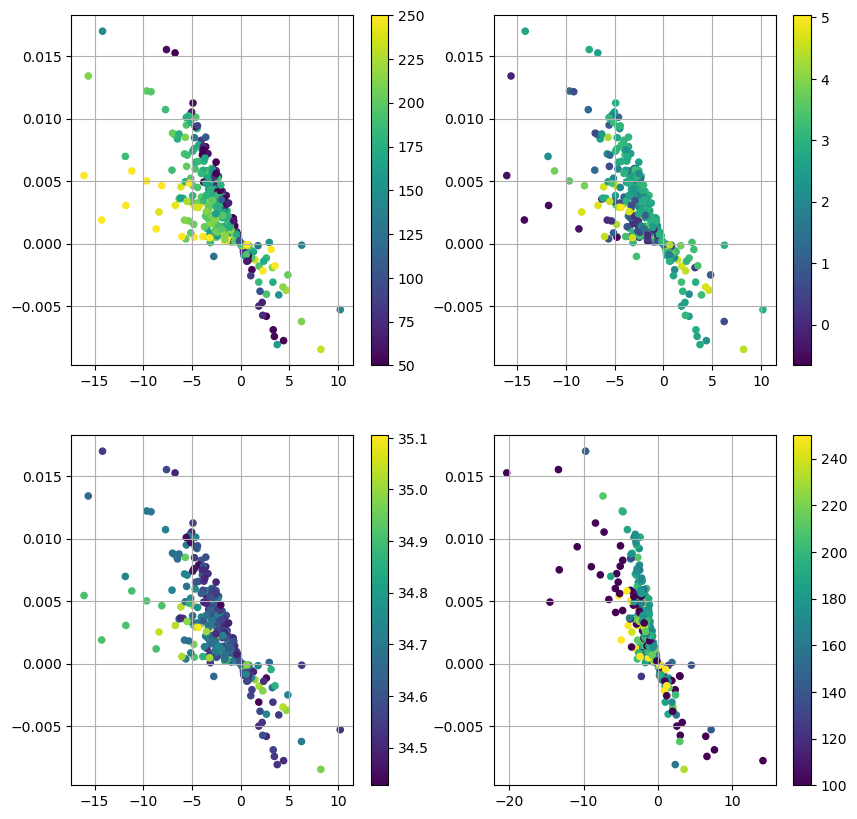

In [ ]:
#fig,(ax1, ax2, ax3, ax4) = plt.subplots(figsize=(10,10), ncols=2, nrows=2)
fig = plt.subplots(figsize=(10,10))
plt.subplot(221)
pos = plt.hist(o2_offset, pH_impact, 20, o2_1500, vmin=50, vmax=250)
plt.colorbar(pos)
plt.grid()

plt.subplot(222)
pos2 = plt.hist(o2_offset, pH_impact, 20, temp_1500)
plt.colorbar(pos2)
plt.grid()

plt.subplot(223)
pos2 = plt.hist(o2_offset, pH_impact, 20, sal_1500)
plt.colorbar(pos2)
plt.grid()

o2_array = np.array(o2_offset).reshape(1,-1)
o2_1500_array = np.array(o2_1500)
pH_impact_array = np.array(pH_impact)

percent_o2 = o2_array/o2_1500_array*100

plt.subplot(224)
pos = plt.hist(percent_o2, pH_impact_array, 20, o2_1500_array, vmin=100, vmax=250)
plt.colorbar(pos)
plt.grid()

plt.savefig(output_dir_figs+ 'pH_impact vs_O2_Offset.png')


In [77]:
len(o2_impact_no3_alone['o2_conc'])

100

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3874/1974826003.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(331)


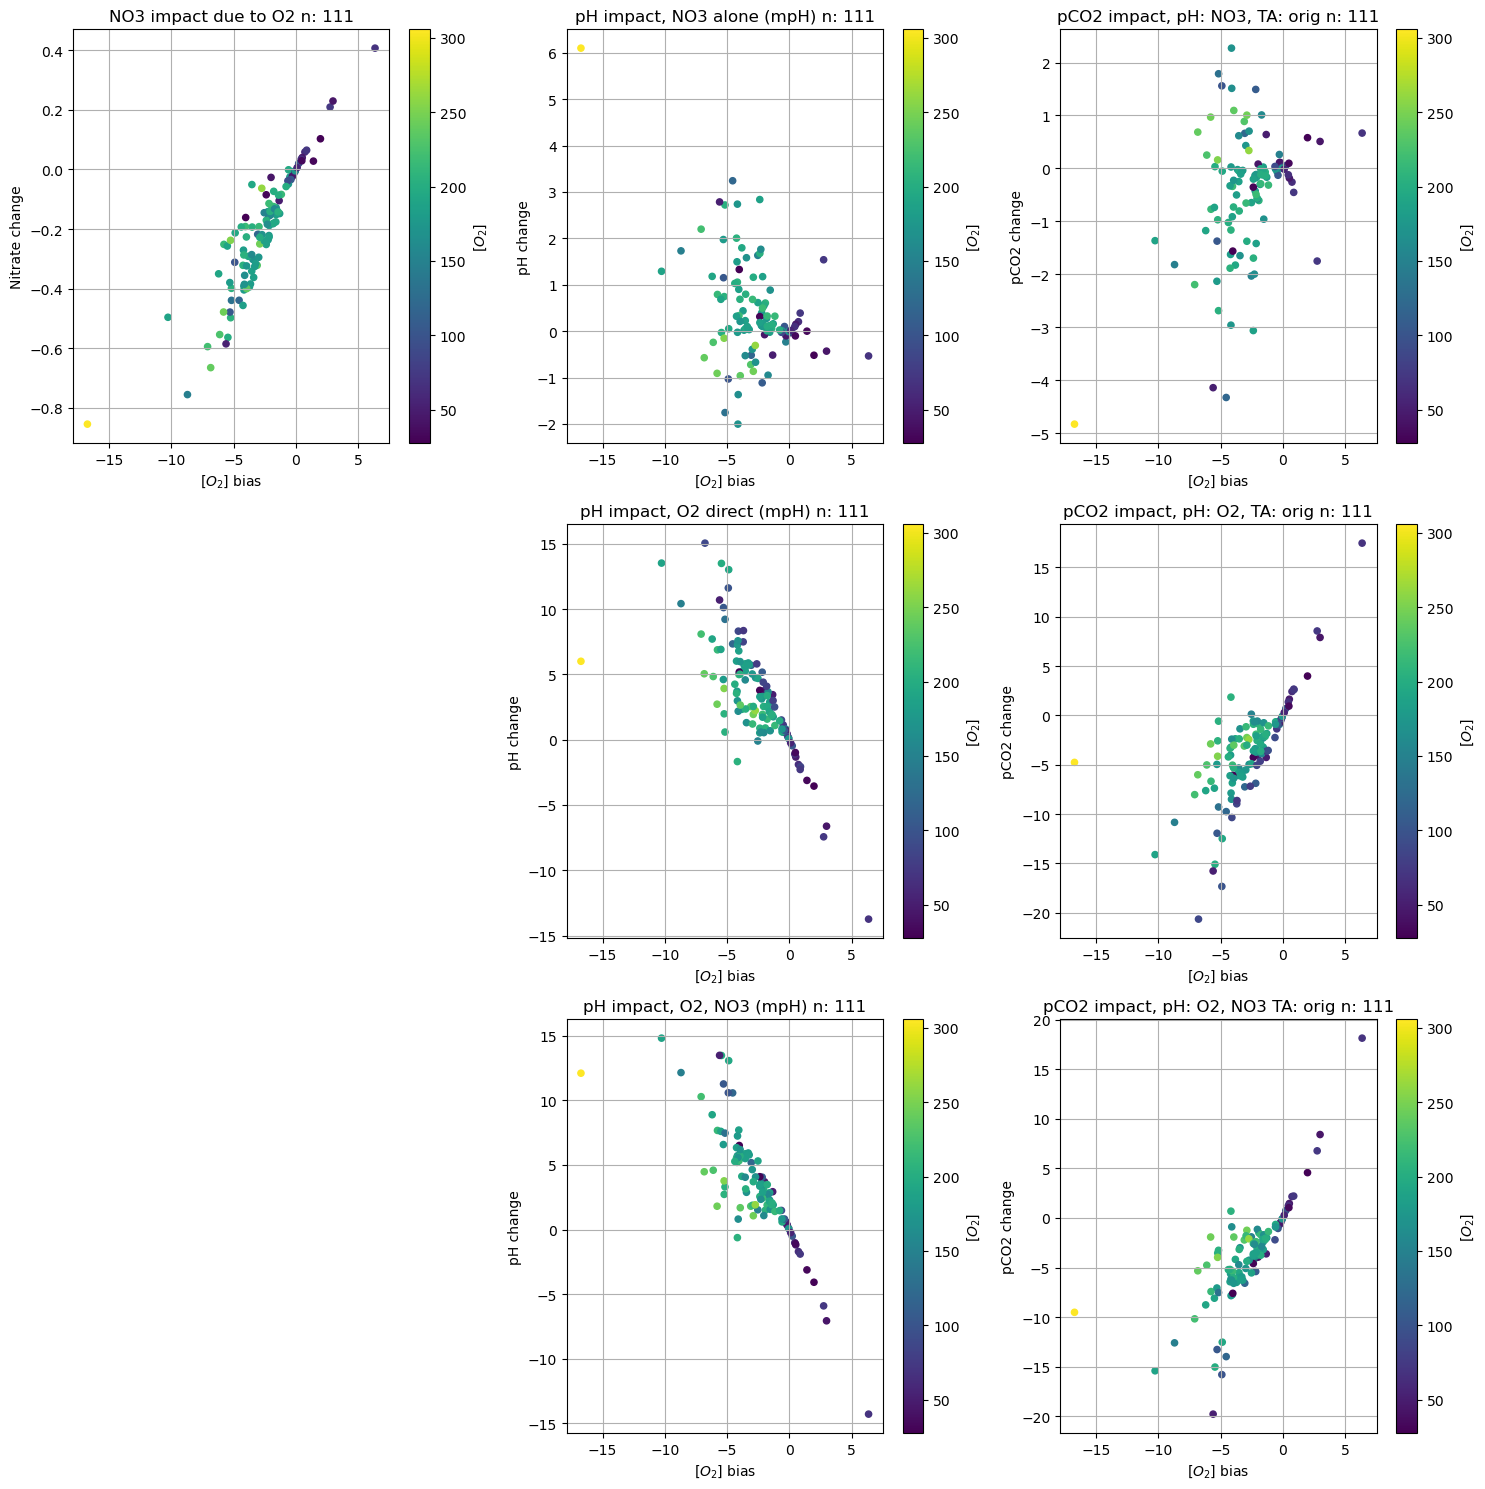

In [ ]:
# plotting total impacts from various combination of factors
fig = plt.subplots(figsize=(15,15))

plt.subplot(331)
pos = plt.scatter(o2_impact_no3_alone['o2_bias'], o2_impact_no3_alone['no3_impact'], 20, o2_impact_no3_alone['o2_conc'])
plt.title('NO3 impact due to O2' + ' n: ' + str(len(o2_impact_no3_alone['o2_conc'])))
plt.ylabel('Nitrate change')
plt.xlabel('$[O_{2}]$ bias')

cbar = plt.colorbar(pos)
cbar.set_label('$[O_{2}]$')
plt.grid()

plt.subplot(332)
pos = plt.scatter(o2_impact_no3_alone['o2_bias'], o2_impact_no3_alone['pH_impact']*1000, 20, o2_impact_no3_alone['o2_conc'])
plt.title('pH impact, NO3 alone (mpH)'+ ' n: ' + str(len(o2_impact_no3_alone['o2_conc'])))
plt.ylabel('pH change')
plt.xlabel('$[O_{2}]$ bias')
cbar = plt.colorbar(pos)
cbar.set_label('$[O_{2}]$')
plt.grid()

# plt.subplot(443)
# pos = plt.scatter(o2_impact_no3_alone['o2_bias'], o2_impact_no3_alone['TA_impact'], 20, o2_impact_no3_alone['o2_conc'])
# plt.title('TA impact, NO3 alone')
# plt.ylabel('TA change')
# plt.xlabel('$[O_{2}]$ bias')
# cbar = plt.colorbar(pos)
# cbar.set_label('$[O_{2}]$')
# plt.grid()

plt.subplot(333)
pos = plt.scatter(o2_impact_no3_alone['o2_bias'], o2_impact_no3_alone['pCO2_impact'], 20, o2_impact_no3_alone['o2_conc'])
plt.title('pCO2 impact, pH: NO3, TA: orig'+ ' n: ' + str(len(o2_impact_no3_alone['o2_conc'])))
plt.ylabel('pCO2 change')
plt.xlabel('$[O_{2}]$ bias')
cbar = plt.colorbar(pos)
cbar.set_label('$[O_{2}]$')
plt.grid()


plt.subplot(335)
pos = plt.scatter(o2_impact_direct['o2_bias'], o2_impact_direct['pH_impact']*1000, 20, o2_impact_direct['o2_conc'])
plt.title('pH impact, O2 direct (mpH)'+ ' n: ' + str(len(o2_impact_no3_alone['o2_conc'])))
plt.ylabel('pH change')
plt.xlabel('$[O_{2}]$ bias')
cbar = plt.colorbar(pos)
cbar.set_label('$[O_{2}]$')
plt.grid()

plt.subplot(336)
pos = plt.scatter(o2_impact_direct['o2_bias'], o2_impact_direct['pCO2_impact'], 20, o2_impact_direct['o2_conc'])
plt.title('pCO2 impact, pH: O2, TA: orig'+ ' n: ' + str(len(o2_impact_no3_alone['o2_conc'])))
plt.ylabel('pCO2 change')
plt.xlabel('$[O_{2}]$ bias')
cbar = plt.colorbar(pos)
cbar.set_label('$[O_{2}]$')
plt.grid()

plt.subplot(338)
pos = plt.scatter(o2_no3_impact_pH['o2_bias'], o2_no3_impact_pH['pH_impact']*1000, 20, o2_no3_impact_pH['o2_conc'])
plt.title('pH impact, O2, NO3 (mpH)'+ ' n: ' + str(len(o2_impact_no3_alone['o2_conc'])))
plt.ylabel('pH change')
plt.xlabel('$[O_{2}]$ bias')
cbar = plt.colorbar(pos)
cbar.set_label('$[O_{2}]$')
plt.grid()

plt.subplot(339)
pos = plt.scatter(o2_no3_impact_pH['o2_bias'], o2_no3_impact_pH['pCO2_impact'], 20, o2_no3_impact_pH['o2_conc'])
plt.title('pCO2 impact, pH: O2, NO3 TA: orig'+ ' n: ' + str(len(o2_impact_no3_alone['o2_conc'])))
plt.ylabel('pCO2 change')
plt.xlabel('$[O_{2}]$ bias')
cbar = plt.colorbar(pos)
cbar.set_label('$[O_{2}]$')
plt.grid()

# plt.subplot(4,4, 16)
# pos = plt.scatter(o2_no3_impact_pH_TA['o2_bias'], o2_no3_impact_pH_TA['pCO2_impact'], 20, o2_no3_impact_pH_TA['o2_conc'])
# plt.title('pCO2 impact, pH: O2, NO3 TA: NO3')
# plt.ylabel('pCO2 change')
# plt.xlabel('$[O_{2}]$ bias')
# cbar = plt.colorbar(pos)
# cbar.set_label('$[O_{2}]$')
# plt.grid()

plt.tight_layout()

if air_cal_only==True:
    plot_filename = 'BGC impacts due to O2 bias - scatter plot - air_cal_only_v2'
else:
    plot_filename = 'BGC impacts due to O2 bias - scatter plot - all pH floats_v2'

plt.savefig(output_dir_figs + plot_filename + '.png', dpi=300)



/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_3874/347565915.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(331)


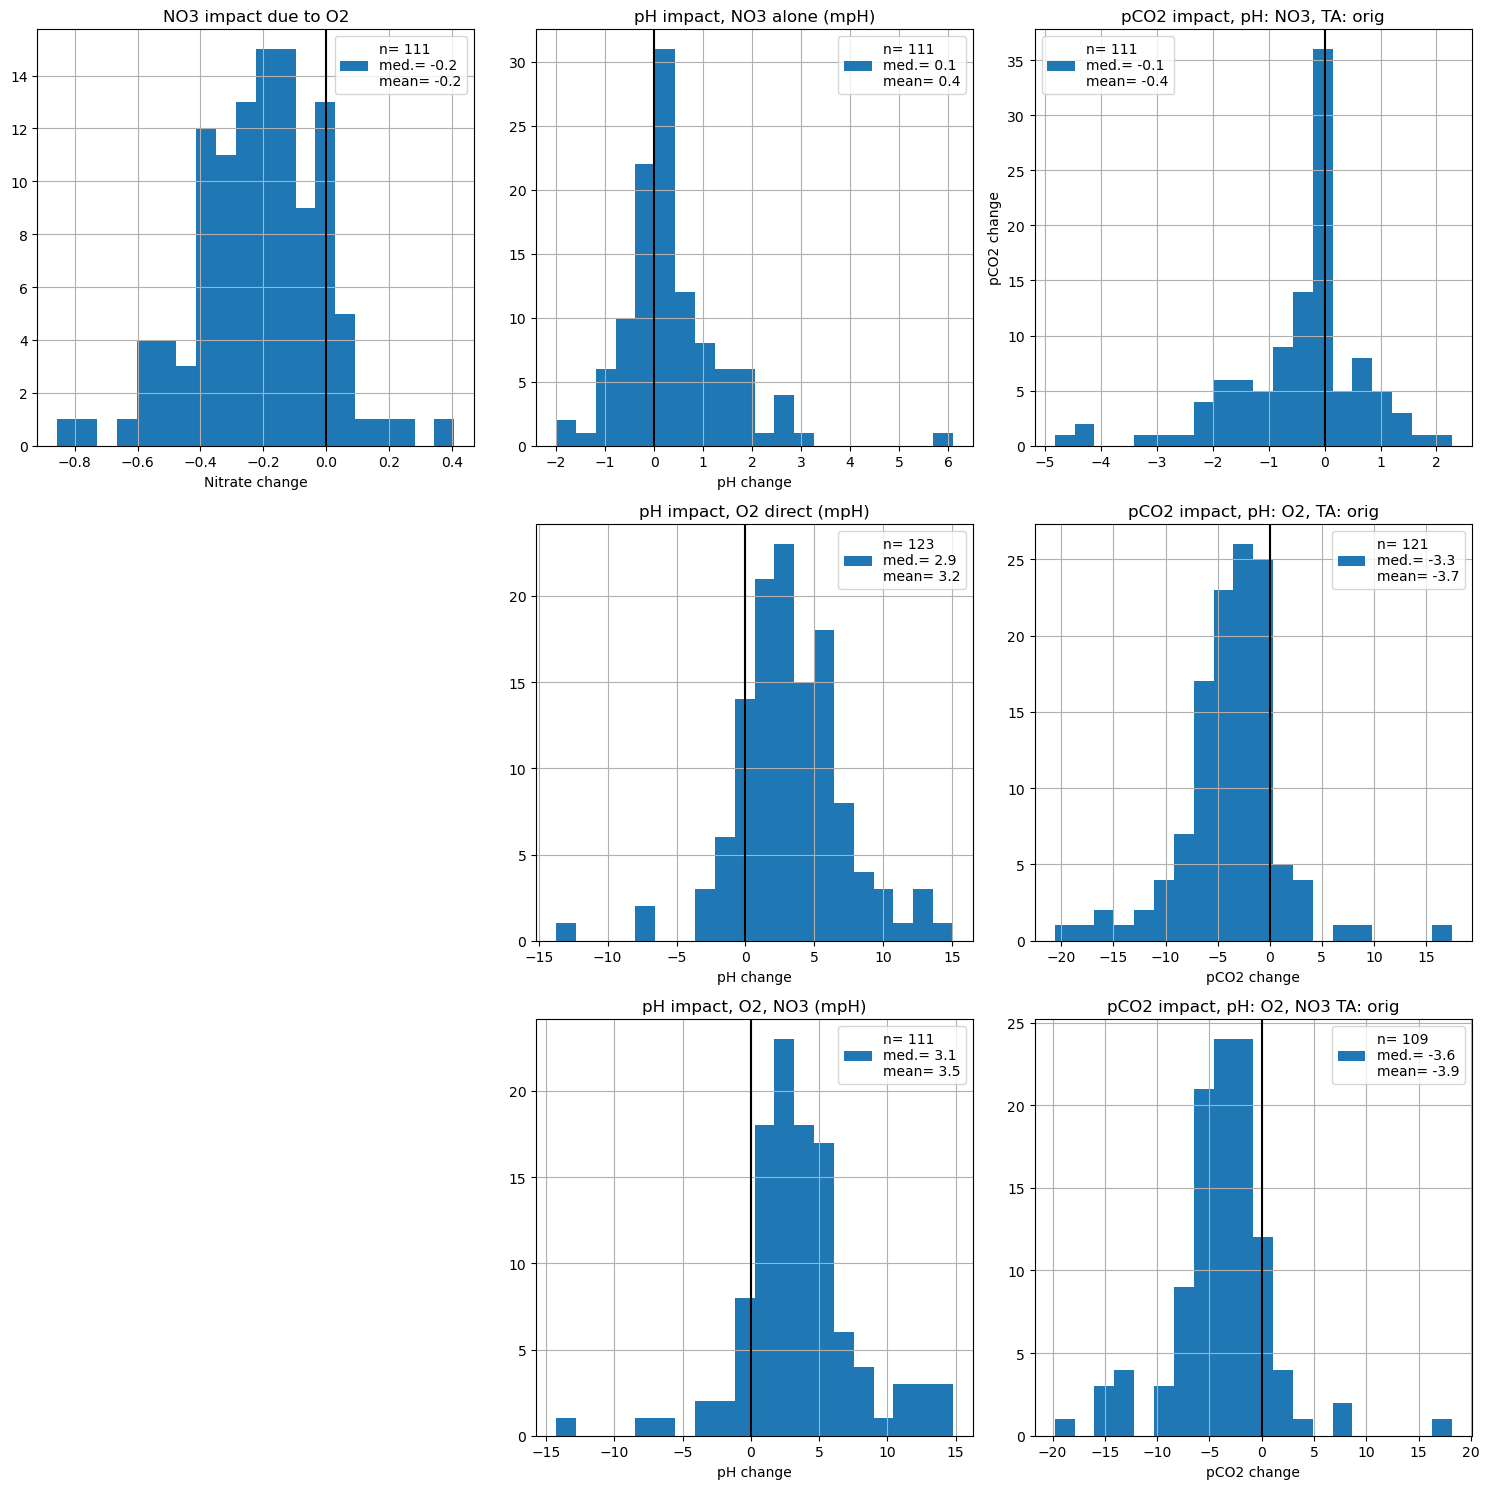

In [39]:
# plotting histograms of total impacts from various combination of factors
fig = plt.subplots(figsize=(15,15))

plt.subplot(331)
nmedian = np.around(o2_impact_no3_alone['no3_impact'].median(), decimals=1)
nmean = np.around(o2_impact_no3_alone['no3_impact'].mean(), decimals=1)

pos = plt.hist(o2_impact_no3_alone['no3_impact'], bins=20, label='n= ' + str(o2_impact_no3_alone['no3_impact'].count()) + '\nmed.= '+str(nmedian) + '\nmean= '+str(nmean) )
plt.title('NO3 impact due to O2')
plt.xlabel('Nitrate change')
plt.grid()

plt.axvline(x=0, color='k')
plt.legend()

plt.subplot(332)
nmedian = np.around(o2_impact_no3_alone['pH_impact'].median()*1000, decimals=1)
nmean = np.around(o2_impact_no3_alone['pH_impact'].mean()*1000, decimals=1)

pos = plt.hist(o2_impact_no3_alone['pH_impact']*1000, bins=20, label='n= ' + str(o2_impact_no3_alone['pH_impact'].count()) + '\nmed.= '+str(nmedian) + '\nmean= '+str(nmean) )
plt.title('pH impact, NO3 alone (mpH)')
plt.xlabel('pH change')
plt.grid()
plt.axvline(x=0, color='k')
plt.legend()

# plt.subplot(443)
# nmedian = np.around(o2_impact_no3_alone['TA_impact'].median(), decimals=1)

# pos = plt.hist(o2_impact_no3_alone['TA_impact'], bins=20, label='n= ' + str(o2_impact_no3_alone['TA_impact'].count()) + '\nmed.= '+str(nmedian) )
# plt.title('TA impact, NO3 alone')
# plt.xlabel('TA change')
# plt.axvline(x=0, color='k')
# plt.legend()
# plt.grid()

plt.subplot(333)
nmedian = np.around(o2_impact_no3_alone['pCO2_impact'].median(), decimals=1)
nmean = np.around(o2_impact_no3_alone['pCO2_impact'].mean(), decimals=1)

pos = plt.hist(o2_impact_no3_alone['pCO2_impact'], bins=20, label='n= ' + str(o2_impact_no3_alone['o2_bias'].count()) + '\nmed.= '+str(nmedian) + '\nmean= '+str(nmean) )
plt.title('pCO2 impact, pH: NO3, TA: orig')
plt.ylabel('pCO2 change')
plt.axvline(x=0, color='k')
plt.legend()
plt.grid()


plt.subplot(335)
nmedian = np.around(o2_impact_direct['pH_impact'].median()*1000, decimals=1)
nmean = np.around(o2_impact_direct['pH_impact'].mean()*1000, decimals=1)

pos = plt.hist(o2_impact_direct['pH_impact']*1000, bins=20, label='n= ' + str(o2_impact_direct['pH_impact'].count()) + '\nmed.= '+str(nmedian) + '\nmean= '+str(nmean) )
plt.title('pH impact, O2 direct (mpH)')
plt.xlabel('pH change')
plt.axvline(x=0, color='k')
plt.legend()
plt.grid()

plt.subplot(336)
nmedian = np.around(o2_impact_direct['pCO2_impact'].median(), decimals=1)
nmean = np.around(o2_impact_direct['pCO2_impact'].mean(), decimals=1)

pos = plt.hist(o2_impact_direct['pCO2_impact'], bins=20, label='n= ' + str(o2_impact_direct['pCO2_impact'].count()) + '\nmed.= '+str(nmedian) + '\nmean= '+str(nmean) )
plt.title('pCO2 impact, pH: O2, TA: orig')
plt.xlabel('pCO2 change')
plt.axvline(x=0, color='k')
plt.legend()
plt.grid()

plt.subplot(338)
nmedian = np.around(o2_no3_impact_pH['pH_impact'].median()*1000, decimals=1)
nmean= np.around(o2_no3_impact_pH['pH_impact'].mean()*1000, decimals=1)

pos = plt.hist(o2_no3_impact_pH['pH_impact']*1000, bins=20, label='n= ' + str(o2_no3_impact_pH['pH_impact'].count()) + '\nmed.= '+str(nmedian) + '\nmean= '+str(nmean) )
plt.title('pH impact, O2, NO3 (mpH)')
plt.xlabel('pH change')
plt.axvline(x=0, color='k')
plt.legend()
plt.grid()

plt.subplot(339)
nmedian = np.around(o2_no3_impact_pH['pCO2_impact'].median(), decimals=1)
nmean = np.around(o2_no3_impact_pH['pCO2_impact'].mean(), decimals=1)

pos = plt.hist(o2_no3_impact_pH['pCO2_impact'], bins=20, label='n= ' + str(o2_no3_impact_pH['pCO2_impact'].count()) + '\nmed.= '+str(nmedian)+ '\nmean= '+str(nmean) )
plt.title('pCO2 impact, pH: O2, NO3 TA: orig')
plt.xlabel('pCO2 change')
plt.axvline(x=0, color='k')
plt.legend()
plt.grid()

# plt.subplot(4,4, 16)
# nmedian = np.around(o2_no3_impact_pH_TA['pCO2_impact'].median(), decimals=1)

# pos = plt.hist(o2_no3_impact_pH_TA['pCO2_impact'], bins=20, label='n= ' + str(o2_no3_impact_pH_TA['pCO2_impact'].count()) + '\nmed.= '+str(nmedian) )
# plt.title('pCO2 impact, pH: O2, NO3 TA: NO3')
# plt.xlabel('pCO2 change')
# plt.axvline(x=0, color='k')
# plt.legend()

# plt.grid()
plt.tight_layout()
#plt.show()

if air_cal_only==True:
    plot_filename = 'BGC impacts due to O2 bias - histogram plot - air_cal_only_v2'
else:
    plot_filename = 'BGC impacts due to O2 bias - histogram plot - all pH floats_v2'


plt.savefig(output_dir_figs + plot_filename + '.png', dpi=300)



In [211]:
o2_no3_impact_pH_TA['pCO2_impact'].mean()

-3.2802547403982056

In [ ]:
upper_25m.TALK_LIAR.mean(dim='N_LEVELS')

<xarray.DataArray 'TALK_LIAR' (N_PROF: 121)>
array([2337.04725934, 2337.46945016, 2337.18075981, 2337.97173045,
       2338.24396065, 2338.62616603, 2338.95581861, 2339.23801804,
       2339.16442203, 2338.91170947, 2338.67228715, 2338.69668968,
       2338.65090941, 2338.74156558, 2338.46134813, 2338.51265376,
       2338.61228298, 2338.74821756, 2337.98892827, 2338.5072482 ,
       2338.41234934, 2338.07009835, 2338.11791962, 2338.18706731,
       2338.21891735, 2338.45129941, 2337.86846881, 2338.22714305,
       2338.83537452, 2338.47597844, 2338.26619699, 2338.39821774,
       2338.71372089, 2338.55678875, 2338.36989647, 2338.20633093,
       2338.49607628, 2338.62743607, 2338.47192671, 2338.47861571,
       2338.50201434, 2338.17336736, 2338.47914541, 2338.96511303,
       2339.245478  , 2338.32433019, 2338.78420219, 2338.8977531 ,
       2339.1617754 , 2339.60598692, 2339.85192129, 2339.11050896,
       2339.29313361, 2338.39538573, 2338.04090705, 2337.90807093,
       2337.74587451, 2337.26672508, 2336.46787834, 2336.03147963,
       2337.66344037, 2336.6117476 , 2336.67585558, 2338.84846657,
       2339.1889326 , 2338.32174969, 2337.79794121, 2345.07448414,
       2340.65287637, 2340.97548128, 2342.53606023, 2342.56828112,
       2341.0042278 , 2336.23691463, 2343.73613447, 2343.74143512,
       2343.65533944, 2342.39089893, 2341.97617257, 2342.37019095,
       2341.82080952, 2342.14563221, 2341.75647799, 2343.26900205,
       2340.50582672, 2345.3760771 , 2339.25172039, 2343.17298069,
       2341.56014165, 2340.9711441 , 2341.91703733, 2342.35411367,
       2342.06332403, 2343.40976114, 2343.40337025, 2344.16278369,
       2347.09067336, 2345.57460725, 2341.7537274 , 2344.92036877,
       2343.65184335, 2344.07450687, 2343.91599929, 2345.56802854,
       2345.64167375, 2342.40918244, 2341.07077157, 2343.58252256,
       2338.71216079, 2342.44976913, 2336.88658132, 2338.67541576,
       2335.8388372 , 2334.28201792, 2335.99769526, 2336.99606411,
       2341.60590858, 2345.32765887, 2341.61484957, 2343.13118545,
       2344.37580658])
Dimensions without coordinates: N_PROF

In [ ]:
display(argo_n)

<xarray.Dataset>
Dimensions:                                       (N_PROF: 23, N_LEVELS: 527)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/23)
    wmo                                           int64 1902382
    CYCLE_NUMBER                                  (N_PROF) float64 1.0 ... 23.0
    LONGITUDE                                     (N_PROF) float64 -30.5 ... ...
    LATITUDE                                      (N_PROF) float64 16.64 ... ...
    JULD_LOCATION                                 (N_PROF) datetime64[ns] 202...
    TEMP_ADJUSTED                                 (N_PROF, N_LEVELS) float32 ...
    ...                                            ...
    pCO2_pH_corr                                  (N_PROF, N_LEVELS) float64 ...
    pH_orig_LIPHR                                 (N_PROF) float64 7.95 ... 7.93
    pH_O2_ADJUST_LIPHR                            (N_PROF) float64 7.95 ... 7...
    PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET  (N_PROF, N_LEVELS) float32 ...
    pCO2_pH_TOTAL_ADJUST_O2_IMPACT                (N_PROF, N_LEVELS) float64 ...
    pCO2_pH_no_bias_corr                          (N_PROF, N_LEVELS) float64 ...

In [ ]:
np.nanmean(profile_data)

123.25746

Text(0, 0.5, 'Pressure (dbar)')

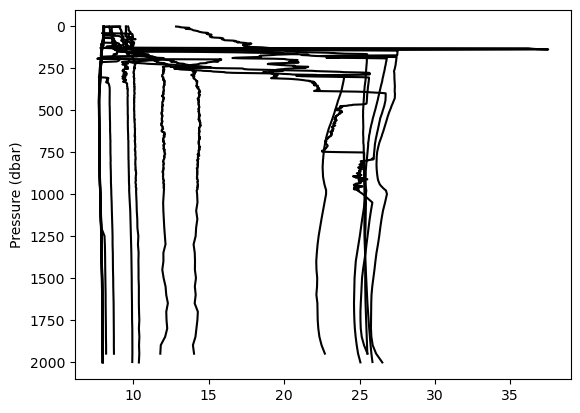

In [ ]:
plt.figure()

for p in range(0, len(argo_n['N_PROF'])):
    profile_pressure = argo_n['PRES_ADJUSTED'].isel(N_PROF=p).values
    profile_data = argo_n['PH_IN_SITU_TOTAL_ADJUSTED'].isel(N_PROF=p).values
    plt.plot(profile_data[~np.isnan(profile_data)]+(p-1)*np.nanmean(profile_data)/10, 
         profile_pressure[~np.isnan(profile_data)], c='black')


plt.gca().invert_yaxis()
#plt.xlabel('Nitrate (µmol/kg)')
plt.ylabel('Pressure (dbar)')

In [ ]:
# check original sprof file
argo_sprof_n = xr.load_dataset(argo_path+'1902382_Sprof.nc')


In [ ]:
argo_sprof_n

<xarray.Dataset>
Dimensions:                          (N_PROF: 23, N_PARAM: 9, N_CALIB: 1,
                                      N_LEVELS: 527)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/93)
    DATA_TYPE                        object b'Argo synthetic profile          '
    FORMAT_VERSION                   object b'1.0 '
    HANDBOOK_VERSION                 object b'1.2 '
    REFERENCE_DATE_TIME              object b'19500101000000'
    DATE_CREATION                    object b'20220825072049'
    DATE_UPDATE                      object b'20220825072049'
    ...                               ...
    NITRATE                          (N_PROF, N_LEVELS) float32 nan nan ... nan
    NITRATE_QC                       (N_PROF, N_LEVELS) object nan nan ... nan
    NITRATE_dPRES                    (N_PROF, N_LEVELS) float32 nan nan ... nan
    NITRATE_ADJUSTED                 (N_PROF, N_LEVELS) float32 nan nan ... nan
    NITRATE_ADJUSTED_QC              (N_PROF, N_LEVELS) object nan nan ... nan
    NITRATE_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 nan nan ... nan
Attributes:
    title:                Argo float vertical profile
    institution:          AOML
    source:               Argo float
    history:              2022-08-25T07:20:49Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.13 (version 09.06.2022 for ARGO_simplified_profile)

In [ ]:
# Function to convert an array from NumPy datetime64 to Python float format
def datetime_to_float(dt):
  return (dt - np.datetime64('1900-01-01')) / np.timedelta64(1,'D')

# Function to convert an array from Python float to NumPy datetime64 format
def float_to_datetime(nums):
  return (nums * np.timedelta64(1,'D')) + np.datetime64('1900-01-01')

# Function to interpolate data from a specified float parameter to a uniform time and pressure grid
def interpolate_depth_section(param_name,specify_qc_flags=None,pres_interval=1.0):
  """
  Arguments:
      param_name: string with netCDF file parameter name (e.g., 'TEMP_ADJUSTED') to interpolate
      specify_qc_flags: None to ignore QC flags
                        or a list of QC flags (e.g., [1,2,3]) indicating which data to retain before interpolation
      pres_interval: vertical resolution for interpolating pressure (z) axis (default: 1.0 dbar)
  
  Returns:
      time_coord: 1-D NumPy array with original profile timestamps in np.datetime64 format
      pres_coord: 1-D NumPy array with a uniform pressure (z) coordinate from 0 dbar to the deepest recorded
                  pressure value, at a resolution of  dbar
      time_grid: 2-D NumPy array with the meshed grid of time_coord
      pres_grid: 2-D NumPy array with the meshed grid of pres_coord
      param_gridded: 2-D NumPy array with the interpolated parameter values at the locations of time_grid and pres_grid

  """

  # New grid points
  time_coord = data['JULD'].values
  pres_coord = np.arange(0,data['PRES'].max(),pres_interval)
  time_grid, pres_grid = np.meshgrid(time_coord,pres_coord)
  time_grid = datetime_to_float(time_grid)     # Convert from np.datetime64 to float

  # 1-D (flattened) versions of old grids and parameter values
  time_1D = np.tile(data['JULD'].values,(len(data['N_LEVELS']),1)).T.flatten()
  pres_1D = data['PRES'].values.flatten()
  param_1D = data[param_name].values.flatten()
  if param_1D.dtype == object:         # If parameter is an array of QC flag data
    param_1D = param_1D.astype(float)  # Convert QC flags from dtype 'object' to float
    interp_method = 'nearest'          # Use nearest-neighbor interpolation for QC flags to avoid unwanted averaging
  else:
    interp_method = 'linear'           # Use bilinear interpolation for normal data fields

  # Extract only values matching specified QC flags
  if specify_qc_flags is not None:
    qc_1D = data[param_name + '_QC'].values.astype(float).flatten()
    qc_mask = np.tile(False,len(qc_1D))
    for qc_flag in specify_qc_flags:
      qc_mask = np.logical_or(qc_mask,qc_1D == qc_flag)
    time_1D = time_1D[qc_mask]
    pres_1D = pres_1D[qc_mask]
    param_1D = param_1D[qc_mask]

  # Remove NaN values before interpolation
  time_1D = datetime_to_float(time_1D[~np.isnan(param_1D)])       # Convert from np.datetime64 to float
  pres_1D = pres_1D[~np.isnan(param_1D)]
  param_1D = param_1D[~np.isnan(param_1D)]

  # Interpolate from irregular points to grid
  param_gridded = interpolate.griddata((time_1D,pres_1D),param_1D,(time_grid,pres_grid),method=interp_method)

  # Return coordinates, grid, and gridded data
  return time_coord, pres_coord, float_to_datetime(time_grid), pres_grid, param_gridded

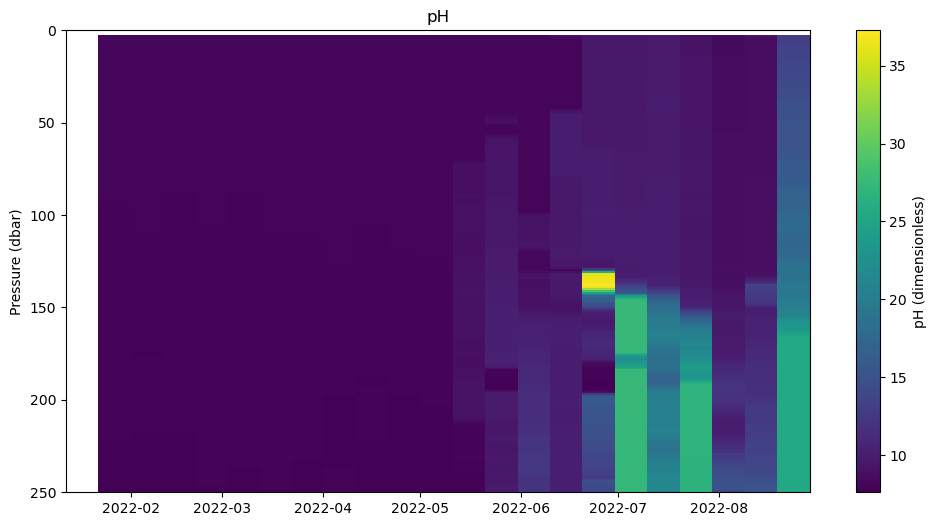

In [ ]:
data = argo_sprof_n
# Interpolate data
param_name = 'PH_IN_SITU_TOTAL_ADJUSTED'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar(label='{0} ({1})'.format(data[param_name].long_name,data[param_name].units))
plt.title(data[param_name].long_name);

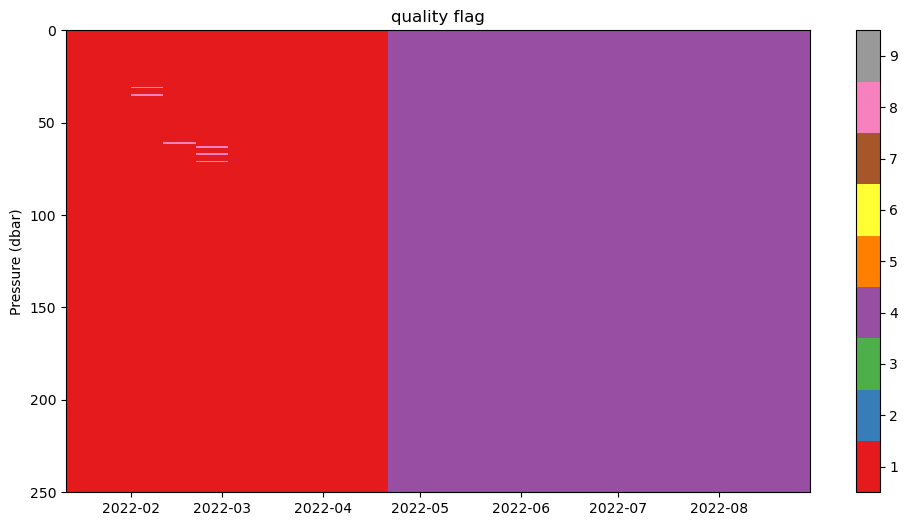

In [ ]:


# Interpolate data
param_name = 'PH_IN_SITU_TOTAL_ADJUSTED_QC'
time_coord, pres_coord, time_grid, pres_grid, param_gridded = interpolate_depth_section(param_name)

# Plot depth section of upper ocean only
plt.figure(figsize=(12,6))
plt.pcolormesh(time_grid,pres_grid,param_gridded,cmap='Set1',vmin=0.5,vmax=9.5)
plt.ylim([0,250])
plt.gca().invert_yaxis()
plt.ylabel('Pressure (dbar)')
plt.colorbar()
plt.title(data[param_name].long_name);
     


In [ ]:
# plotting pCO2 impacts for floats:
derivedlist = []
for file in os.listdir(argo_path_derived):
    if file.endswith('derived_3.nc'):
        derivedlist.append(file)

In [ ]:
pCO2_impact_np = np.array(pCO2_impact)
o2_offset_3 = np.array(o2_offset_3)

print(np.nanmin(pCO2_impact_np))
print(np.nanmax(pCO2_impact_np))

1.870103557566527
1.870103557566527


In [ ]:
pCO2

In [ ]:

msk = (pCO2_impact_np>-300) & (pCO2_impact_np<300)
pCO2_impact_np[msk]

array([], dtype=float64)

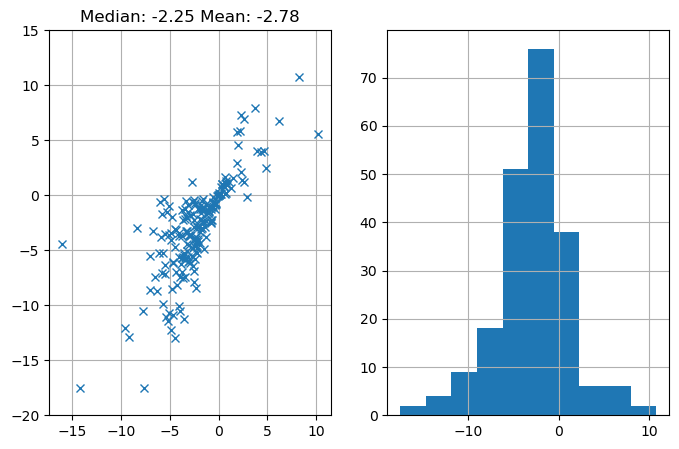

In [ ]:
plt.figure(figsize=(8,5))

plt.subplot(121)
plt.plot(o2_offset_3, pCO2_impact_np, marker = 'x', linestyle='None')
plt.ylim(-20,15)
plt.title('Median: ' + "%.2f" % np.nanmedian(pCO2_impact_np) + ' Mean: ' "%.2f" % np.nanmean(pCO2_impact_np))
plt.grid()
plt.subplot(122)
plt.hist(pCO2_impact_np)
plt.grid()

plt.savefig(output_dir_figs + 'float_pCO2_impact_no_mask.png')


In [ ]:
print(np.mean(glodap_offsets.DOXY_ADJUSTED_offset))
print(np.nanmedian(glodap_offsets.DOXY_ADJUSTED_offset))

plt.figure(figsize=(20,12))
plt.hist(glodap_offsets.DOXY_ADJUSTED_offset, bins=np.linspace(-400, 400, 401))

plt.xlabel('DOXY Offset')
plt.savefig(output_dir_figs + 'Glodap_offsets_doxy_plus_minus_400.png')


NameError: name 'glodap_offsets' is not defined

Looking at impact of oxygen offsets on pH / pCO2 / Nitrate / DIC

In [ ]:
# load glodap_offsets with cal info:

glodap_offsets = xr.load_dataset(output_dir+'glodap_offsets_withcalibration.nc')

In [ ]:
#create meta groups based on calibration groups (air cal, no air cal, no cal)
g = glodap_offsets.o2_calib_group.copy(deep=True)
g = g.where(glodap_offsets.o2_calib_group == 'air cal','not air')
glodap_offsets['o2_calib_air'] = xr.where(glodap_offsets.o2_calib_group=='bad','no cal',g)

glodap_offsets['o2_calib_air_key'] = xr.where(glodap_offsets.o2_calib_air=='air cal',1,0)

glodap_offsets['o2_not_air_key'] = xr.where(glodap_offsets.o2_calib_air=='not air',-1,0)
glodap_offsets['o2_cal_key'] = glodap_offsets['o2_calib_air_key'] + glodap_offsets['o2_not_air_key']

wmo_means = glodap_offsets.groupby('main_float_wmo').mean(...)

In [ ]:
# new dataset of air_cal floats only
a = wmo_means.where(wmo_means.o2_cal_key>0.6, drop=True)

In [ ]:
# checking for inconsistencies in interpolated vs. derived lengths

pH_count = 0;
# load float files, use offset information to calculate impact 
for n in range(2,3): #range(0, len(a.main_float_wmo)):
    wmo_n = int(a.main_float_wmo[n].values)
    
    argo_derived_n = xr.load_dataset(argo_path+ 'derived/' + str(wmo_n) + '_derived.nc')

    print(str(n) + ': ' + str(a.main_float_wmo[n].values))

    print(argo_wmo[wmo_n].PRES_ADJUSTED.shape)
    print(argo_derived_n.PRES_ADJUSTED.shape)
    print(' ')
    

2: 1901362
(36, 951)
(18, 78)
 


In [ ]:
argo_derived_n.PRES_ADJUSTED[0,:]

<xarray.DataArray 'PRES_ADJUSTED' (N_LEVELS: 78)>
array([   6.7     ,   10.9     ,   15.9     ,   21.1     ,   25.900002,
         30.900002,   35.3     ,   40.7     ,   45.4     ,   50.4     ,
         60.3     ,   70.2     ,   80.2     ,   90.299995,  100.7     ,
        110.6     ,  120.2     ,  129.9     ,  140.      ,  150.5     ,
        189.59999 ,  200.8     ,  210.3     ,  220.5     ,  230.4     ,
        240.8     ,  250.09999 ,  260.      ,  270.      ,  280.6     ,
        290.7     ,  300.2     ,  310.6     ,  320.2     ,  330.      ,
        340.      ,  350.40002 ,  374.90002 ,  400.7     ,  425.30002 ,
        450.5     ,  475.      ,  500.6     ,  524.9     ,  550.      ,
        575.2     ,  600.5     ,  625.3     ,  650.3     ,  674.9     ,
        700.3     ,  750.8     ,  800.60004 ,  849.8     ,  900.10004 ,
        950.2     , 1000.60004 , 1049.7     , 1099.5     , 1150.      ,
       1200.      , 1250.7999  , 1300.      , 1349.8999  , 1400.      ,
       1450.2999  , 1500.2999  , 1549.8999  , 1600.1     , 1650.2     ,
       1700.2999  , 1750.3999  , 1800.3999  , 1850.2     , 1900.3999  ,
       1950.1     ,         nan,         nan], dtype=float32)
Dimensions without coordinates: N_LEVELS

In [ ]:
argo_wmo[wmo_n].TEMP_ADJUSTED[:,0]

<xarray.DataArray 'TEMP_ADJUSTED' (N_PROF: 36)>
array([5.958705, 6.061573, 5.986551, 6.152714, 5.939236, 6.016245, 6.049644,
       6.164514, 6.204602, 6.236   , 6.153162, 6.296157, 6.23022 , 6.24085 ,
       6.243927, 6.233834, 6.328376, 6.32239 , 5.958705, 6.061573, 5.986551,
       6.152714, 5.939236, 6.016245, 6.049644, 6.164514, 6.204602, 6.236   ,
       6.153162, 6.296157, 6.23022 , 6.24085 , 6.243927, 6.233834, 6.328376,
       6.32239 ])
Dimensions without coordinates: N_PROF

In [ ]:
LIPHR_path = liar_dir

pH_count = 0;
# load float files, use offset information to calculate impact 
for n in range(37,38): #range(0, len(a.main_float_wmo)):
    wmo_n = int(a.main_float_wmo[n].values)
    
    argo_derived_n = xr.load_dataset(argo_path+ 'derived/' + str(wmo_n) + '_derived.nc')

    # check if the float also has pH
    if 'PH_IN_SITU_TOTAL_ADJUSTED' in argo_derived_n.keys() and np.any(~np.isnan(argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED)):
        pH_count = pH_count+1
        print(str(n) + ': ' + str(a.main_float_wmo[n].values))

    else:
        continue
    
    nprof = argo_derived_n.LATITUDE.shape[0]

    #test_pH = np.empty(nprof, dtype=float)
    
    # initialize coordinate and measurement arrays
    Coordinates_all = np.empty([nprof, 3],dtype=float)
    Coordinates_all[:] = np.nan
       
    Measurements_all = np.empty([nprof, 4],dtype=float)
    Measurements_all[:] = np.nan
    
    MeasIDVec = [1, 7, 3, 6]
    for p in range(nprof):
        index_1500 = argo_wmo[wmo_n].PRES_ADJUSTED[p,:]==1500

        #argo_wmo[5904659].PSAL_ADJUSTED[0,index_1500]
        Coordinates_all[p,:] = np.stack((argo_wmo[wmo_n].LONGITUDE[p].values.flatten(), 
                            argo_wmo[wmo_n].LATITUDE[p].values.flatten(), 
                            argo_wmo[wmo_n].PRES_ADJUSTED[p,index_1500].values.flatten()),
                            axis=1)
        Measurements_all[p,:] = np.stack((argo_wmo[wmo_n].PSAL_ADJUSTED[p,index_1500].values.flatten(), 
                             argo_wmo[wmo_n].TEMP_ADJUSTED[p,index_1500].values.flatten(), 
                             argo_wmo[wmo_n].NITRATE_ADJUSTED[p,index_1500].values.flatten(), 
                             argo_wmo[wmo_n].DOXY_ADJUSTED[p,index_1500].values.flatten()),
                             axis=1)
    
    
    # calculate LIPHR pH for all profiles
    test_pH = carbon_utils.LIPHR_matlab(LIPHR_path,
                                    Coordinates_all.tolist(),
                                    Measurements_all.tolist(),
                                    MeasIDVec, 
                                    OAAdjustTF = False)  
       
    Measurements_o2_offset = np.concatenate(([Measurements_all[:,0]], 
                                  [Measurements_all[:,1]],
                                  [Measurements_all[:,2]],
                                  [Measurements_all[:,3]] + a.DOXY_ADJUSTED_offset[n].values))
    Measurements_o2_offset = np.transpose(Measurements_o2_offset)
    # calculate LIPHR pH for all profiles
    new_pH = carbon_utils.LIPHR_matlab(LIPHR_path,
                                    Coordinates_all.tolist(),
                                    Measurements_o2_offset.tolist(),
                                    MeasIDVec, 
                                    OAAdjustTF = False)  
    argo_derived_n['pH_orig_LIPHR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
    argo_derived_n.pH_orig_LIPHR[:] = test_pH[:,0]

    argo_derived_n['pH_O2_ADJUST_LIPHR'] = (['N_PROF'],np.empty(argo_derived_n.PRES_ADJUSTED.shape[0])) #nprof x nlevel
    argo_derived_n.pH_O2_ADJUST_LIPHR[:] = new_pH[:,0]
    # difference between pH_O2_orig_LIPHR and PH_IN_SITU_TOTAL_ADJUSTED- should that average 0? 
    # Impact of O2 can be seen in the test_pH minus new_pH average 
    
    argo_derived_n['PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET'] = \
        argo_derived_n.PH_IN_SITU_TOTAL_ADJUSTED + np.mean(new_pH - test_pH)
    
    argo_derived_n.to_netcdf(argo_path+ 'derived/' + str(wmo_n) + '_derived_2.nc')


37: 5904659


In [ ]:
argo_wmo[5904659]

<xarray.Dataset>
Dimensions:                    (N_PROF: 153, N_LEVELS: 951)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/20)
    wmo                        (N_PROF) int64 5904659 5904659 ... 5904659
    profile                    (N_PROF) float64 ...
    juld                       (N_PROF) datetime64[ns] ...
    LATITUDE                   (N_PROF) float64 ...
    LONGITUDE                  (N_PROF) float64 ...
    num_var                    (N_PROF) float64 ...
    ...                         ...
    spice                      (N_PROF, N_LEVELS) float64 ...
    PRES_ADJUSTED              (N_PROF, N_LEVELS) float64 ...
    DIC                        (N_PROF, N_LEVELS) float64 ...
    TALK_LIAR                  (N_PROF, N_LEVELS) float64 ...
    pCO2                       (N_PROF, N_LEVELS) float64 ...
    pCO2_pH_corr               (N_PROF, N_LEVELS) float64 ...

In [ ]:
argo_derived_n

        #call CO2sys to calculate pCO2 with bias correction and no O2 correction (check against original)
        results = pyco2.sys(
                par1=argo_derived_n.TALK_LIAR, 
                par2=argo_derived_n.pH_insitu_corr,
                par1_type=1,
                par2_type=3,
                temperature=argo_n.TEMP_ADJUSTED, 
                pressure=argo_n.PRES_ADJUSTED, 
                salinity=argo_n.PSAL_ADJUSTED, 
                temperature_out=25.* np.ones(argo_n.PRES_ADJUSTED.shape), #fixed 25C temperature
                pressure_out=argo_n.PRES_ADJUSTED,
                total_silicate=SI,
                total_phosphate=PO4,
                opt_pH_scale = 1, #total
                opt_k_carbonic=10, #Lueker et al. 2000
                opt_k_bisulfate=1, # Dickson 1990 (Note, matlab co2sys combines KSO4 with TB. option 3 = KSO4 of Dickson & TB of Lee 2010)
                opt_total_borate=2, # Lee et al. 2010
                opt_k_fluoride=2, # Perez and Fraga 1987
                opt_buffers_mode=1,
                )

<xarray.Dataset>
Dimensions:                                       (N_PROF: 153, N_LEVELS: 558)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/22)
    wmo                                           int64 5904659
    CYCLE_NUMBER                                  (N_PROF) float64 1.0 ... 153.0
    LONGITUDE                                     (N_PROF) float64 -55.38 ......
    LATITUDE                                      (N_PROF) float64 -59.64 ......
    JULD_LOCATION                                 (N_PROF) datetime64[ns] 201...
    TEMP_ADJUSTED                                 (N_PROF, N_LEVELS) float32 ...
    ...                                            ...
    TALK_LIAR                                     (N_PROF, N_LEVELS) float64 ...
    pCO2                                          (N_PROF, N_LEVELS) float64 ...
    pCO2_pH_corr                                  (N_PROF, N_LEVELS) float64 ...
    pH_orig_LIPHR                                 (N_PROF) float64 7.88 ... 7...
    pH_O2_ADJUST_LIPHR                            (N_PROF) float64 7.875 ... ...
    PH_IN_SITU_TOTAL_ADJUSTED_w_O2_ADJUST_OFFSET  (N_PROF, N_LEVELS) float32 ...

-0.0036396733963356244

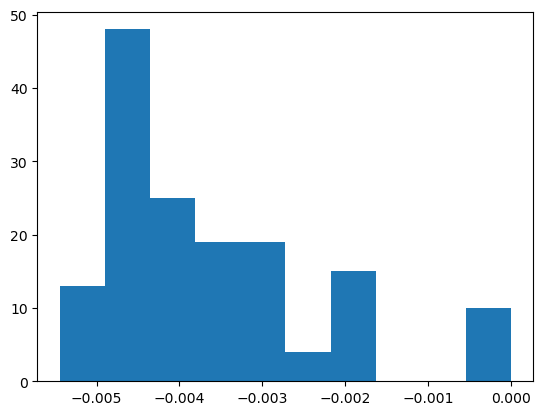

In [ ]:
test_pH - new_pH
plt.hist(new_pH - test_pH)
np.mean(new_pH - test_pH)

<xarray.DataArray 'PH_IN_SITU_TOTAL_ADJUSTED' ()>
array(0.00315701)

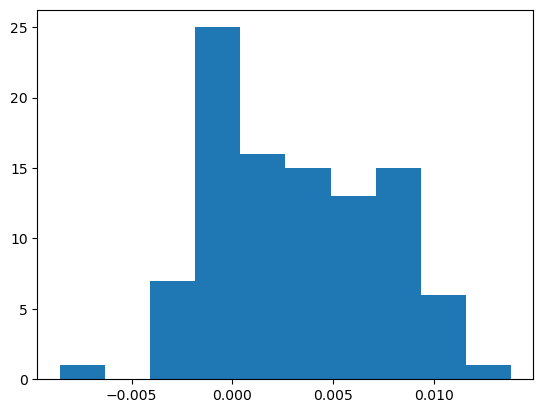

In [ ]:
plt.hist(argo_wmo[wmo_n].PH_IN_SITU_TOTAL_ADJUSTED[:,index_1500] - test_pH)
np.mean(argo_wmo[wmo_n].PH_IN_SITU_TOTAL_ADJUSTED[:,index_1500] - test_pH)